# Setup
Comment out javascript if jupyter widgets not installed

In [1]:
%%javascript
utils.load_extension('collapsible_headings/main')
utils.load_extension('hide_input/main')
utils.load_extension('autosavetime/main')
utils.load_extension('execute_time/ExecuteTime')
utils.load_extension('code_prettify/code_prettify')
utils.load_extension('scroll_down/main')
utils.load_extension('jupyter-js-widgets/extension')

<IPython.core.display.Javascript object>

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
from pathlib import Path
from dataset import Video

# Create dataset
Creating data for input to the model is a little tricky. Details in the readme.

In [4]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door4/train') #in jpg format, from included script
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door4/labels.json') # in json format, from included script

In [5]:
from dataset_import import get_training_set, get_validation_set, get_test_set
from model import generate_model
class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    
input_args=Args()

In [6]:
from spatial_transforms2 import (
    Compose, Normalize, Scale, CenterCrop, CornerCrop, MultiScaleCornerCrop,
    MultiScaleRandomCrop, RandomHorizontalFlip, ToTensor)
from temporal_transforms2 import LoopPadding, TemporalRandomCrop
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose

In [7]:
norm_value=255 #for rgb data

scale_step=0.84089 #for the kinetics dataset
scales = [1]
n_scales=5
for i in range(1, n_scales):
    scales.append(scales[-1] * scale_step)
    
sample_size=112 # default for kinetics
sample_duration=4 # my choosen window size
norm_method = Normalize([110.636/norm_value, 103.1606/norm_value, 96.29/norm_value], 
                        [38.756/norm_value, 37.8824/norm_value, 40.03/norm_value]) #per the averages of the dataset
crop_method = MultiScaleRandomCrop(scales, sample_size)
spatial_transform = Compose([
            crop_method,
            RandomHorizontalFlip(),
            ToTensor(norm_value), norm_method])

In [8]:
temporal_transform = TemporalRandomCrop(sample_duration)
target_transform = ClassLabel()

In [9]:
training_data = get_training_set(input_args, spatial_transform,
                                 temporal_transform, target_transform)

dataset loading [0/223]


In [10]:
batch_size=16 #32 was too large!
n_threads=4
train_loader = torch.utils.data.DataLoader(
            training_data,
            batch_size=batch_size,
            shuffle=True,
            num_workers=n_threads,
            pin_memory=True)

# Validation Set
I have one video for training, another for test, and another for validation. Using the ActivityNet data crawler, these videos are easily transformed into the appropriate format as described in the readme.

In [14]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door4/val')
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door4/labels.json')

class Args:
    dataset = 'kinetics'
    video_path = v_path
    annotation_path = a_path
    n_val_samples=5
    sample_duration=4
    
val_args=Args()

In [15]:
validation_data = get_validation_set(
    val_args, spatial_transform, temporal_transform, target_transform)

dataset loading [0/69]


In [16]:
val_loader = torch.utils.data.DataLoader(
    validation_data,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

# Load Pre-Trained Model
### First, import kinetics pretrained model exactly as is

In [17]:
from models import resnet, pre_act_resnet, wide_resnet, resnext, densenet
import torch.nn as nn

model = resnext.resnet101(
    sample_size=112, #height and width of inputs
    sample_duration=4, #temporal, 16!!!
    num_classes=400) 

In [18]:
#from opts import parse_opts
from model import generate_model
class Args:
    sample_size = 112
    sample_duration = 4 #16!!!
    n_classes = 400
    mode='feature'
    model_name='resnext'
    model_depth=101
    resnet_shortcut='B'
    resnext_cardinality=32
    no_cuda=False
    batch_size=16
    n_threads=4

opt=Args()
model=generate_model(opt)

pretrain_path=Path('/media/tris/tris_files/github/csce_courses/video-classification-3d-cnn-pytorch/resnext-101-kinetics.pth')
model_data = torch.load(pretrain_path)
model.load_state_dict(model_data['state_dict'])
model.eval()

DataParallel(
  (module): ResNeXt(
    (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResNeXtBottleneck(
        (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
        (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
        (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

### With the model correcly imported, add a final layer to reduce the output size to my three desired outputs

In [19]:
for param in model.parameters():
    param.requires_grad = False
#     # Replace the last fully-connected layer
#     # Parameters of newly constructed modules have requires_grad=True by default
# model.fc = nn.Sequential(
#     nn.Linear(400, 256), #256 is arbitrary
#     nn.ReLU(),
#     nn.Linear(256,3),
#     nn.LogSoftmax(dim=1))
# model.fc.requires_grad=True
# model.cuda()
# model.eval()


In [20]:
my_module = nn.Sequential(
    nn.Linear(2048, 256), #256 is arbitrary
    nn.ReLU(),
    nn.Linear(256,3))
    #nn.Softmax(dim=1))#dim consider putting the softmax back in, unsure of dimension

In [21]:
my_model = nn.Sequential(model, my_module) #combining the pre-trained and new model
my_model.cuda() #put it on the gpu
my_model.eval()

Sequential(
  (0): DataParallel(
    (module): ResNeXt(
      (conv1): Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): ResNeXtBottleneck(
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), groups=32, bias=False)
          (bn2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv3d(128, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine

### We now have the original model, plus a few extra layers to resize the output

In [22]:
from torch import optim# Loss and optimizer
from torch.optim import lr_scheduler
criterion = nn.CrossEntropyLoss()
criterion=criterion.cuda()

dampening=0.5 #0.9
optimizer = optim.SGD(
            my_model.parameters(),
            lr=4e-2,
            momentum=0.9,
            dampening=dampening,
            weight_decay=1e-3, #1e-3 #how important is this if I'm only training the last few layers? Set to 0?
            nesterov=False)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', patience=5)
# Definatley need some tuning here
    

In [23]:
from utils import Logger
import os
results_path=Path('/media/tris/tris_files/github/csce_courses/')

train_logger = Logger(os.path.join(results_path, 'train.log'),
                      ['epoch', 'loss', 'acc', 'lr'])
train_batch_logger = Logger(os.path.join(results_path, 'train_batch.log'),
                            ['epoch', 'batch', 'iter', 'loss', 'acc', 'lr'])
val_logger = Logger(
            os.path.join(results_path, 'val.log'), ['epoch', 'loss', 'acc'])

In [24]:
begin_epoch=1
n_epoch=200
from train2 import train_epoch
from validation import val_epoch

for i in range(begin_epoch, n_epoch + 1):
    train_epoch(i, train_loader, my_model, criterion, optimizer, opt,
                    train_logger, train_batch_logger)
    validation_loss = val_epoch(i, val_loader, my_model, criterion, opt,
                                    val_logger)
    scheduler.step(validation_loss)

train at epoch 1
Epoch: [1][1/14]	Time 0.729 (0.729)	Data 0.417 (0.417)	Loss 1.1030 (1.1030)	Acc 0.188 (0.188)
Epoch: [1][2/14]	Time 0.026 (0.378)	Data 0.002 (0.210)	Loss 0.9980 (1.0505)	Acc 0.562 (0.375)
Epoch: [1][3/14]	Time 0.083 (0.279)	Data 0.058 (0.159)	Loss 1.1456 (1.0822)	Acc 0.562 (0.438)
Epoch: [1][4/14]	Time 0.077 (0.229)	Data 0.052 (0.132)	Loss 0.7162 (0.9907)	Acc 0.750 (0.516)
Epoch: [1][5/14]	Time 0.078 (0.199)	Data 0.053 (0.116)	Loss 1.0701 (1.0066)	Acc 0.625 (0.538)
Epoch: [1][6/14]	Time 0.077 (0.178)	Data 0.052 (0.106)	Loss 0.7806 (0.9689)	Acc 0.750 (0.573)
Epoch: [1][7/14]	Time 0.077 (0.164)	Data 0.053 (0.098)	Loss 1.1934 (1.0010)	Acc 0.500 (0.562)
Epoch: [1][8/14]	Time 0.079 (0.153)	Data 0.054 (0.093)	Loss 0.8118 (0.9773)	Acc 0.688 (0.578)
Epoch: [1][9/14]	Time 0.085 (0.146)	Data 0.060 (0.089)	Loss 0.7368 (0.9506)	Acc 0.750 (0.597)
Epoch: [1][10/14]	Time 0.080 (0.139)	Data 0.054 (0.086)	Loss 0.7503 (0.9306)	Acc 0.875 (0.625)
Epoch: [1][11/14]	Time 0.084 (0.134)	Data 

Epoch: [3][1/22]	Time 0.215 (0.215)	Data 0.190 (0.190)	Loss 0.4520 (0.4520)	Acc 0.938 (0.938)
Epoch: [3][2/22]	Time 0.072 (0.144)	Data 0.048 (0.119)	Loss 1.1063 (0.7791)	Acc 0.438 (0.688)
Epoch: [3][3/22]	Time 0.071 (0.119)	Data 0.050 (0.096)	Loss 0.6592 (0.7392)	Acc 0.750 (0.708)
Epoch: [3][4/22]	Time 0.072 (0.107)	Data 0.052 (0.085)	Loss 0.7432 (0.7402)	Acc 0.688 (0.703)
Epoch: [3][5/22]	Time 0.073 (0.100)	Data 0.053 (0.079)	Loss 0.7215 (0.7365)	Acc 0.750 (0.713)
Epoch: [3][6/22]	Time 0.073 (0.096)	Data 0.053 (0.074)	Loss 0.3424 (0.6708)	Acc 1.000 (0.760)
Epoch: [3][7/22]	Time 0.073 (0.093)	Data 0.053 (0.071)	Loss 0.6490 (0.6677)	Acc 0.812 (0.768)
Epoch: [3][8/22]	Time 0.073 (0.090)	Data 0.053 (0.069)	Loss 0.9630 (0.7046)	Acc 0.562 (0.742)
Epoch: [3][9/22]	Time 0.073 (0.088)	Data 0.053 (0.067)	Loss 0.4326 (0.6744)	Acc 1.000 (0.771)
Epoch: [3][10/22]	Time 0.073 (0.087)	Data 0.053 (0.066)	Loss 0.9908 (0.7060)	Acc 0.375 (0.731)
Epoch: [3][11/22]	Time 0.074 (0.085)	Data 0.053 (0.065)	Los

Epoch: [5][16/22]	Time 0.073 (0.087)	Data 0.054 (0.066)	Loss 0.8148 (0.7590)	Acc 0.625 (0.664)
Epoch: [5][17/22]	Time 0.074 (0.087)	Data 0.055 (0.065)	Loss 0.6760 (0.7542)	Acc 0.625 (0.662)
Epoch: [5][18/22]	Time 0.074 (0.086)	Data 0.055 (0.065)	Loss 1.0718 (0.7718)	Acc 0.562 (0.656)
Epoch: [5][19/22]	Time 0.077 (0.085)	Data 0.057 (0.064)	Loss 0.8831 (0.7777)	Acc 0.562 (0.651)
Epoch: [5][20/22]	Time 0.079 (0.085)	Data 0.059 (0.064)	Loss 1.0272 (0.7901)	Acc 0.500 (0.644)
Epoch: [5][21/22]	Time 0.079 (0.085)	Data 0.059 (0.064)	Loss 0.9167 (0.7962)	Acc 0.688 (0.646)
Epoch: [5][22/22]	Time 0.080 (0.085)	Data 0.060 (0.064)	Loss 0.9583 (0.8004)	Acc 0.556 (0.643)
train at epoch 6
Epoch: [6][1/14]	Time 0.388 (0.388)	Data 0.357 (0.357)	Loss 0.4457 (0.4457)	Acc 0.812 (0.812)
Epoch: [6][2/14]	Time 0.081 (0.234)	Data 0.055 (0.206)	Loss 0.7214 (0.5836)	Acc 0.750 (0.781)
Epoch: [6][3/14]	Time 0.088 (0.185)	Data 0.061 (0.158)	Loss 0.8234 (0.6635)	Acc 0.750 (0.771)
Epoch: [6][4/14]	Time 0.079 (0.159)	

Epoch: [8][10/14]	Time 0.075 (0.101)	Data 0.052 (0.075)	Loss 0.4313 (0.6983)	Acc 0.750 (0.719)
Epoch: [8][11/14]	Time 0.078 (0.099)	Data 0.054 (0.074)	Loss 0.9305 (0.7194)	Acc 0.625 (0.710)
Epoch: [8][12/14]	Time 0.076 (0.097)	Data 0.054 (0.072)	Loss 1.3821 (0.7746)	Acc 0.438 (0.688)
Epoch: [8][13/14]	Time 0.077 (0.095)	Data 0.054 (0.071)	Loss 0.8195 (0.7781)	Acc 0.688 (0.688)
Epoch: [8][14/14]	Time 0.078 (0.094)	Data 0.055 (0.069)	Loss 0.6467 (0.7692)	Acc 0.733 (0.691)
validation at epoch 8
Epoch: [8][1/22]	Time 0.214 (0.214)	Data 0.190 (0.190)	Loss 0.3770 (0.3770)	Acc 0.875 (0.875)
Epoch: [8][2/22]	Time 0.074 (0.144)	Data 0.050 (0.120)	Loss 0.9359 (0.6564)	Acc 0.438 (0.656)
Epoch: [8][3/22]	Time 0.070 (0.119)	Data 0.049 (0.096)	Loss 0.6242 (0.6457)	Acc 0.875 (0.729)
Epoch: [8][4/22]	Time 0.073 (0.108)	Data 0.053 (0.085)	Loss 0.7185 (0.6639)	Acc 0.625 (0.703)
Epoch: [8][5/22]	Time 0.074 (0.101)	Data 0.053 (0.079)	Loss 0.8066 (0.6924)	Acc 0.750 (0.713)
Epoch: [8][6/22]	Time 0.074 (0.09

Epoch: [10][10/22]	Time 0.074 (0.089)	Data 0.054 (0.068)	Loss 1.3005 (0.5991)	Acc 0.500 (0.762)
Epoch: [10][11/22]	Time 0.074 (0.088)	Data 0.055 (0.067)	Loss 1.5793 (0.6882)	Acc 0.562 (0.744)
Epoch: [10][12/22]	Time 0.074 (0.087)	Data 0.054 (0.066)	Loss 1.2697 (0.7366)	Acc 0.750 (0.745)
Epoch: [10][13/22]	Time 0.073 (0.086)	Data 0.054 (0.065)	Loss 1.1696 (0.7700)	Acc 0.312 (0.712)
Epoch: [10][14/22]	Time 0.075 (0.085)	Data 0.055 (0.064)	Loss 0.9385 (0.7820)	Acc 0.688 (0.710)
Epoch: [10][15/22]	Time 0.073 (0.084)	Data 0.053 (0.063)	Loss 0.7962 (0.7829)	Acc 0.562 (0.700)
Epoch: [10][16/22]	Time 0.073 (0.083)	Data 0.054 (0.063)	Loss 1.0329 (0.7986)	Acc 0.625 (0.695)
Epoch: [10][17/22]	Time 0.076 (0.083)	Data 0.056 (0.062)	Loss 0.6852 (0.7919)	Acc 0.688 (0.695)
Epoch: [10][18/22]	Time 0.074 (0.082)	Data 0.054 (0.062)	Loss 0.5612 (0.7791)	Acc 0.625 (0.691)
Epoch: [10][19/22]	Time 0.074 (0.082)	Data 0.054 (0.061)	Loss 0.6649 (0.7731)	Acc 0.562 (0.684)
Epoch: [10][20/22]	Time 0.074 (0.082)	Da

train at epoch 13
Epoch: [13][1/14]	Time 0.347 (0.347)	Data 0.318 (0.318)	Loss 0.5276 (0.5276)	Acc 0.750 (0.750)
Epoch: [13][2/14]	Time 0.083 (0.215)	Data 0.058 (0.188)	Loss 0.6905 (0.6091)	Acc 0.688 (0.719)
Epoch: [13][3/14]	Time 0.088 (0.173)	Data 0.061 (0.146)	Loss 0.5247 (0.5809)	Acc 0.812 (0.750)
Epoch: [13][4/14]	Time 0.086 (0.151)	Data 0.059 (0.124)	Loss 1.0710 (0.7034)	Acc 0.562 (0.703)
Epoch: [13][5/14]	Time 0.085 (0.138)	Data 0.060 (0.111)	Loss 0.7545 (0.7136)	Acc 0.750 (0.713)
Epoch: [13][6/14]	Time 0.089 (0.130)	Data 0.060 (0.103)	Loss 0.4031 (0.6619)	Acc 0.812 (0.729)
Epoch: [13][7/14]	Time 0.084 (0.123)	Data 0.059 (0.097)	Loss 0.9403 (0.7017)	Acc 0.625 (0.714)
Epoch: [13][8/14]	Time 0.088 (0.119)	Data 0.061 (0.092)	Loss 0.7947 (0.7133)	Acc 0.750 (0.719)
Epoch: [13][9/14]	Time 0.084 (0.115)	Data 0.060 (0.089)	Loss 0.4929 (0.6888)	Acc 0.812 (0.729)
Epoch: [13][10/14]	Time 0.086 (0.112)	Data 0.061 (0.086)	Loss 0.7988 (0.6998)	Acc 0.688 (0.725)
Epoch: [13][11/14]	Time 0.080 (

Epoch: [15][1/22]	Time 0.219 (0.219)	Data 0.191 (0.191)	Loss 0.2782 (0.2782)	Acc 0.938 (0.938)
Epoch: [15][2/22]	Time 0.073 (0.146)	Data 0.046 (0.118)	Loss 0.9002 (0.5892)	Acc 0.438 (0.688)
Epoch: [15][3/22]	Time 0.071 (0.121)	Data 0.050 (0.096)	Loss 0.7033 (0.6272)	Acc 0.688 (0.688)
Epoch: [15][4/22]	Time 0.074 (0.109)	Data 0.054 (0.085)	Loss 0.6617 (0.6358)	Acc 0.688 (0.688)
Epoch: [15][5/22]	Time 0.075 (0.102)	Data 0.055 (0.079)	Loss 0.8237 (0.6734)	Acc 0.625 (0.675)
Epoch: [15][6/22]	Time 0.078 (0.098)	Data 0.058 (0.076)	Loss 0.2617 (0.6048)	Acc 1.000 (0.729)
Epoch: [15][7/22]	Time 0.088 (0.097)	Data 0.068 (0.075)	Loss 0.5234 (0.5932)	Acc 0.875 (0.750)
Epoch: [15][8/22]	Time 0.085 (0.095)	Data 0.064 (0.073)	Loss 1.0414 (0.6492)	Acc 0.562 (0.727)
Epoch: [15][9/22]	Time 0.082 (0.094)	Data 0.061 (0.072)	Loss 0.1541 (0.5942)	Acc 1.000 (0.757)
Epoch: [15][10/22]	Time 0.084 (0.093)	Data 0.064 (0.071)	Loss 1.1409 (0.6488)	Acc 0.562 (0.738)
Epoch: [15][11/22]	Time 0.086 (0.092)	Data 0.063 

Epoch: [17][16/22]	Time 0.073 (0.082)	Data 0.054 (0.062)	Loss 0.8668 (0.7848)	Acc 0.625 (0.691)
Epoch: [17][17/22]	Time 0.075 (0.082)	Data 0.055 (0.061)	Loss 0.6968 (0.7796)	Acc 0.750 (0.695)
Epoch: [17][18/22]	Time 0.073 (0.081)	Data 0.054 (0.061)	Loss 0.6171 (0.7706)	Acc 0.750 (0.698)
Epoch: [17][19/22]	Time 0.073 (0.081)	Data 0.054 (0.061)	Loss 0.6118 (0.7622)	Acc 0.875 (0.707)
Epoch: [17][20/22]	Time 0.074 (0.081)	Data 0.055 (0.060)	Loss 0.6228 (0.7552)	Acc 0.625 (0.703)
Epoch: [17][21/22]	Time 0.073 (0.080)	Data 0.054 (0.060)	Loss 0.6983 (0.7525)	Acc 0.750 (0.705)
Epoch: [17][22/22]	Time 0.073 (0.080)	Data 0.054 (0.060)	Loss 0.6521 (0.7499)	Acc 0.556 (0.701)
train at epoch 18
Epoch: [18][1/14]	Time 0.295 (0.295)	Data 0.267 (0.267)	Loss 0.8049 (0.8049)	Acc 0.750 (0.750)
Epoch: [18][2/14]	Time 0.077 (0.186)	Data 0.051 (0.159)	Loss 0.9493 (0.8771)	Acc 0.625 (0.688)
Epoch: [18][3/14]	Time 0.079 (0.150)	Data 0.054 (0.124)	Loss 0.5090 (0.7544)	Acc 0.750 (0.708)
Epoch: [18][4/14]	Time 0.

Epoch: [20][7/14]	Time 0.080 (0.129)	Data 0.053 (0.104)	Loss 0.8408 (0.7110)	Acc 0.688 (0.723)
Epoch: [20][8/14]	Time 0.077 (0.123)	Data 0.053 (0.098)	Loss 0.7906 (0.7209)	Acc 0.562 (0.703)
Epoch: [20][9/14]	Time 0.079 (0.118)	Data 0.053 (0.093)	Loss 0.6450 (0.7125)	Acc 0.750 (0.708)
Epoch: [20][10/14]	Time 0.075 (0.114)	Data 0.052 (0.089)	Loss 0.9146 (0.7327)	Acc 0.750 (0.713)
Epoch: [20][11/14]	Time 0.079 (0.111)	Data 0.055 (0.086)	Loss 0.9371 (0.7513)	Acc 0.688 (0.710)
Epoch: [20][12/14]	Time 0.077 (0.108)	Data 0.054 (0.083)	Loss 0.3971 (0.7218)	Acc 0.875 (0.724)
Epoch: [20][13/14]	Time 0.078 (0.105)	Data 0.054 (0.081)	Loss 0.4080 (0.6977)	Acc 0.938 (0.740)
Epoch: [20][14/14]	Time 0.079 (0.104)	Data 0.055 (0.079)	Loss 1.1601 (0.7288)	Acc 0.467 (0.722)
validation at epoch 20
Epoch: [20][1/22]	Time 0.212 (0.212)	Data 0.184 (0.184)	Loss 0.2527 (0.2527)	Acc 0.938 (0.938)
Epoch: [20][2/22]	Time 0.067 (0.140)	Data 0.046 (0.115)	Loss 1.0485 (0.6506)	Acc 0.438 (0.688)
Epoch: [20][3/22]	Time

Epoch: [22][7/22]	Time 0.073 (0.094)	Data 0.053 (0.073)	Loss 1.0709 (0.7404)	Acc 0.688 (0.777)
Epoch: [22][8/22]	Time 0.074 (0.092)	Data 0.055 (0.071)	Loss 1.0616 (0.7806)	Acc 0.438 (0.734)
Epoch: [22][9/22]	Time 0.075 (0.090)	Data 0.055 (0.069)	Loss 0.2246 (0.7188)	Acc 1.000 (0.764)
Epoch: [22][10/22]	Time 0.073 (0.088)	Data 0.053 (0.067)	Loss 0.9294 (0.7398)	Acc 0.375 (0.725)
Epoch: [22][11/22]	Time 0.075 (0.087)	Data 0.055 (0.066)	Loss 1.1578 (0.7778)	Acc 0.750 (0.727)
Epoch: [22][12/22]	Time 0.073 (0.086)	Data 0.053 (0.065)	Loss 0.8107 (0.7806)	Acc 0.562 (0.714)
Epoch: [22][13/22]	Time 0.073 (0.085)	Data 0.053 (0.064)	Loss 1.1239 (0.8070)	Acc 0.125 (0.668)
Epoch: [22][14/22]	Time 0.075 (0.084)	Data 0.054 (0.063)	Loss 0.9396 (0.8165)	Acc 0.688 (0.670)
Epoch: [22][15/22]	Time 0.073 (0.083)	Data 0.053 (0.063)	Loss 0.9390 (0.8246)	Acc 0.438 (0.654)
Epoch: [22][16/22]	Time 0.074 (0.083)	Data 0.054 (0.062)	Loss 0.9756 (0.8341)	Acc 0.562 (0.648)
Epoch: [22][17/22]	Time 0.074 (0.082)	Data 

train at epoch 25
Epoch: [25][1/14]	Time 0.292 (0.292)	Data 0.263 (0.263)	Loss 0.8579 (0.8579)	Acc 0.688 (0.688)
Epoch: [25][2/14]	Time 0.074 (0.183)	Data 0.049 (0.156)	Loss 0.3773 (0.6176)	Acc 0.875 (0.781)
Epoch: [25][3/14]	Time 0.083 (0.150)	Data 0.054 (0.122)	Loss 0.9916 (0.7423)	Acc 0.688 (0.750)
Epoch: [25][4/14]	Time 0.073 (0.131)	Data 0.048 (0.103)	Loss 0.5473 (0.6936)	Acc 0.812 (0.766)
Epoch: [25][5/14]	Time 0.080 (0.120)	Data 0.054 (0.094)	Loss 0.8011 (0.7151)	Acc 0.625 (0.738)
Epoch: [25][6/14]	Time 0.077 (0.113)	Data 0.052 (0.087)	Loss 0.7750 (0.7250)	Acc 0.688 (0.729)
Epoch: [25][7/14]	Time 0.077 (0.108)	Data 0.053 (0.082)	Loss 0.4219 (0.6817)	Acc 0.938 (0.759)
Epoch: [25][8/14]	Time 0.080 (0.104)	Data 0.055 (0.079)	Loss 0.7924 (0.6956)	Acc 0.625 (0.742)
Epoch: [25][9/14]	Time 0.076 (0.101)	Data 0.053 (0.076)	Loss 1.1340 (0.7443)	Acc 0.438 (0.708)
Epoch: [25][10/14]	Time 0.077 (0.099)	Data 0.054 (0.073)	Loss 0.5909 (0.7289)	Acc 0.750 (0.713)
Epoch: [25][11/14]	Time 0.078 (

Epoch: [27][1/22]	Time 0.217 (0.217)	Data 0.194 (0.194)	Loss 0.2695 (0.2695)	Acc 0.938 (0.938)
Epoch: [27][2/22]	Time 0.076 (0.147)	Data 0.051 (0.123)	Loss 0.8905 (0.5800)	Acc 0.688 (0.812)
Epoch: [27][3/22]	Time 0.068 (0.121)	Data 0.049 (0.098)	Loss 0.6713 (0.6105)	Acc 0.625 (0.750)
Epoch: [27][4/22]	Time 0.074 (0.109)	Data 0.054 (0.087)	Loss 0.6428 (0.6185)	Acc 0.688 (0.734)
Epoch: [27][5/22]	Time 0.075 (0.102)	Data 0.054 (0.080)	Loss 0.8903 (0.6729)	Acc 0.562 (0.700)
Epoch: [27][6/22]	Time 0.074 (0.098)	Data 0.054 (0.076)	Loss 0.2221 (0.5978)	Acc 1.000 (0.750)
Epoch: [27][7/22]	Time 0.073 (0.094)	Data 0.053 (0.073)	Loss 0.5044 (0.5844)	Acc 0.812 (0.759)
Epoch: [27][8/22]	Time 0.075 (0.092)	Data 0.055 (0.070)	Loss 0.8657 (0.6196)	Acc 0.562 (0.734)
Epoch: [27][9/22]	Time 0.074 (0.090)	Data 0.054 (0.069)	Loss 0.1161 (0.5637)	Acc 1.000 (0.764)
Epoch: [27][10/22]	Time 0.074 (0.088)	Data 0.054 (0.067)	Loss 1.0916 (0.6164)	Acc 0.500 (0.738)
Epoch: [27][11/22]	Time 0.075 (0.087)	Data 0.054 

Epoch: [29][16/22]	Time 0.073 (0.082)	Data 0.054 (0.062)	Loss 0.8417 (0.7702)	Acc 0.562 (0.707)
Epoch: [29][17/22]	Time 0.076 (0.082)	Data 0.056 (0.062)	Loss 0.7802 (0.7708)	Acc 0.688 (0.706)
Epoch: [29][18/22]	Time 0.072 (0.081)	Data 0.054 (0.061)	Loss 0.6087 (0.7618)	Acc 0.688 (0.705)
Epoch: [29][19/22]	Time 0.073 (0.081)	Data 0.055 (0.061)	Loss 0.6003 (0.7533)	Acc 0.875 (0.714)
Epoch: [29][20/22]	Time 0.075 (0.081)	Data 0.056 (0.061)	Loss 0.5623 (0.7437)	Acc 0.688 (0.713)
Epoch: [29][21/22]	Time 0.073 (0.080)	Data 0.054 (0.060)	Loss 0.9065 (0.7515)	Acc 0.688 (0.711)
Epoch: [29][22/22]	Time 0.073 (0.080)	Data 0.055 (0.060)	Loss 0.6907 (0.7499)	Acc 0.556 (0.707)
train at epoch 30
Epoch: [30][1/14]	Time 0.295 (0.295)	Data 0.264 (0.264)	Loss 0.7112 (0.7112)	Acc 0.688 (0.688)
Epoch: [30][2/14]	Time 0.074 (0.185)	Data 0.047 (0.155)	Loss 0.7652 (0.7382)	Acc 0.750 (0.719)
Epoch: [30][3/14]	Time 0.078 (0.149)	Data 0.052 (0.121)	Loss 0.6391 (0.7052)	Acc 0.562 (0.667)
Epoch: [30][4/14]	Time 0.

Epoch: [32][7/14]	Time 0.077 (0.099)	Data 0.052 (0.073)	Loss 0.5334 (0.6302)	Acc 0.812 (0.768)
Epoch: [32][8/14]	Time 0.080 (0.097)	Data 0.055 (0.071)	Loss 0.5251 (0.6171)	Acc 0.875 (0.781)
Epoch: [32][9/14]	Time 0.076 (0.095)	Data 0.052 (0.069)	Loss 1.1644 (0.6779)	Acc 0.438 (0.743)
Epoch: [32][10/14]	Time 0.077 (0.093)	Data 0.054 (0.067)	Loss 0.5147 (0.6616)	Acc 0.812 (0.750)
Epoch: [32][11/14]	Time 0.078 (0.092)	Data 0.055 (0.066)	Loss 0.6524 (0.6608)	Acc 0.688 (0.744)
Epoch: [32][12/14]	Time 0.077 (0.090)	Data 0.054 (0.065)	Loss 0.9685 (0.6864)	Acc 0.562 (0.729)
Epoch: [32][13/14]	Time 0.078 (0.089)	Data 0.054 (0.064)	Loss 0.8225 (0.6969)	Acc 0.562 (0.716)
Epoch: [32][14/14]	Time 0.078 (0.089)	Data 0.055 (0.064)	Loss 0.7833 (0.7027)	Acc 0.733 (0.717)
validation at epoch 32
Epoch: [32][1/22]	Time 0.215 (0.215)	Data 0.190 (0.190)	Loss 0.3768 (0.3768)	Acc 0.875 (0.875)
Epoch: [32][2/22]	Time 0.075 (0.145)	Data 0.050 (0.120)	Loss 0.8744 (0.6256)	Acc 0.750 (0.812)
Epoch: [32][3/22]	Time

Epoch: [34][7/22]	Time 0.074 (0.093)	Data 0.054 (0.070)	Loss 0.5633 (0.5581)	Acc 0.875 (0.804)
Epoch: [34][8/22]	Time 0.075 (0.091)	Data 0.055 (0.068)	Loss 0.8703 (0.5972)	Acc 0.562 (0.773)
Epoch: [34][9/22]	Time 0.074 (0.089)	Data 0.054 (0.067)	Loss 0.1055 (0.5425)	Acc 1.000 (0.799)
Epoch: [34][10/22]	Time 0.073 (0.087)	Data 0.053 (0.065)	Loss 1.0729 (0.5956)	Acc 0.562 (0.775)
Epoch: [34][11/22]	Time 0.075 (0.086)	Data 0.055 (0.064)	Loss 1.3870 (0.6675)	Acc 0.438 (0.744)
Epoch: [34][12/22]	Time 0.074 (0.085)	Data 0.054 (0.064)	Loss 0.6904 (0.6694)	Acc 0.750 (0.745)
Epoch: [34][13/22]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 1.2249 (0.7122)	Acc 0.250 (0.707)
Epoch: [34][14/22]	Time 0.074 (0.084)	Data 0.055 (0.062)	Loss 0.7438 (0.7144)	Acc 0.688 (0.705)
Epoch: [34][15/22]	Time 0.074 (0.083)	Data 0.054 (0.062)	Loss 0.8274 (0.7220)	Acc 0.625 (0.700)
Epoch: [34][16/22]	Time 0.073 (0.082)	Data 0.054 (0.061)	Loss 0.9190 (0.7343)	Acc 0.625 (0.695)
Epoch: [34][17/22]	Time 0.074 (0.082)	Data 

Epoch: [36][22/22]	Time 0.078 (0.086)	Data 0.058 (0.063)	Loss 0.7405 (0.7369)	Acc 0.556 (0.687)
train at epoch 37
Epoch: [37][1/14]	Time 0.275 (0.275)	Data 0.234 (0.234)	Loss 0.6858 (0.6858)	Acc 0.812 (0.812)
Epoch: [37][2/14]	Time 0.074 (0.174)	Data 0.047 (0.140)	Loss 0.3973 (0.5416)	Acc 0.875 (0.844)
Epoch: [37][3/14]	Time 0.089 (0.146)	Data 0.061 (0.114)	Loss 0.6181 (0.5671)	Acc 0.812 (0.833)
Epoch: [37][4/14]	Time 0.082 (0.130)	Data 0.057 (0.100)	Loss 0.7684 (0.6174)	Acc 0.625 (0.781)
Epoch: [37][5/14]	Time 0.086 (0.121)	Data 0.061 (0.092)	Loss 0.7297 (0.6399)	Acc 0.562 (0.738)
Epoch: [37][6/14]	Time 0.086 (0.115)	Data 0.061 (0.087)	Loss 0.6016 (0.6335)	Acc 0.688 (0.729)
Epoch: [37][7/14]	Time 0.086 (0.111)	Data 0.061 (0.083)	Loss 0.5258 (0.6181)	Acc 0.750 (0.732)
Epoch: [37][8/14]	Time 0.084 (0.108)	Data 0.060 (0.080)	Loss 0.6459 (0.6216)	Acc 0.750 (0.734)
Epoch: [37][9/14]	Time 0.084 (0.105)	Data 0.060 (0.078)	Loss 0.6000 (0.6192)	Acc 0.812 (0.743)
Epoch: [37][10/14]	Time 0.086 (

Epoch: [39][13/14]	Time 0.077 (0.097)	Data 0.054 (0.072)	Loss 0.5736 (0.6392)	Acc 0.750 (0.736)
Epoch: [39][14/14]	Time 0.081 (0.096)	Data 0.057 (0.071)	Loss 0.5412 (0.6326)	Acc 0.733 (0.735)
validation at epoch 39
Epoch: [39][1/22]	Time 0.214 (0.214)	Data 0.186 (0.186)	Loss 0.3013 (0.3013)	Acc 1.000 (1.000)
Epoch: [39][2/22]	Time 0.069 (0.141)	Data 0.048 (0.117)	Loss 0.8098 (0.5555)	Acc 0.750 (0.875)
Epoch: [39][3/22]	Time 0.073 (0.119)	Data 0.053 (0.096)	Loss 0.7088 (0.6066)	Acc 0.625 (0.792)
Epoch: [39][4/22]	Time 0.074 (0.107)	Data 0.053 (0.085)	Loss 0.5888 (0.6021)	Acc 0.875 (0.812)
Epoch: [39][5/22]	Time 0.074 (0.101)	Data 0.054 (0.079)	Loss 0.7509 (0.6319)	Acc 0.625 (0.775)
Epoch: [39][6/22]	Time 0.074 (0.096)	Data 0.054 (0.075)	Loss 0.2866 (0.5743)	Acc 1.000 (0.812)
Epoch: [39][7/22]	Time 0.073 (0.093)	Data 0.054 (0.072)	Loss 0.5850 (0.5759)	Acc 0.875 (0.821)
Epoch: [39][8/22]	Time 0.075 (0.091)	Data 0.054 (0.070)	Loss 0.9904 (0.6277)	Acc 0.562 (0.789)
Epoch: [39][9/22]	Time 0.

Epoch: [41][13/22]	Time 0.074 (0.084)	Data 0.053 (0.063)	Loss 1.1096 (0.7233)	Acc 0.312 (0.702)
Epoch: [41][14/22]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 0.8266 (0.7307)	Acc 0.750 (0.705)
Epoch: [41][15/22]	Time 0.073 (0.083)	Data 0.053 (0.062)	Loss 0.8207 (0.7367)	Acc 0.625 (0.700)
Epoch: [41][16/22]	Time 0.073 (0.082)	Data 0.054 (0.062)	Loss 0.8417 (0.7433)	Acc 0.625 (0.695)
Epoch: [41][17/22]	Time 0.074 (0.082)	Data 0.055 (0.061)	Loss 0.7427 (0.7432)	Acc 0.688 (0.695)
Epoch: [41][18/22]	Time 0.074 (0.081)	Data 0.055 (0.061)	Loss 0.5748 (0.7339)	Acc 0.688 (0.694)
Epoch: [41][19/22]	Time 0.074 (0.081)	Data 0.054 (0.060)	Loss 0.5205 (0.7226)	Acc 0.812 (0.701)
Epoch: [41][20/22]	Time 0.075 (0.081)	Data 0.056 (0.060)	Loss 0.6340 (0.7182)	Acc 0.625 (0.697)
Epoch: [41][21/22]	Time 0.073 (0.080)	Data 0.054 (0.060)	Loss 0.7575 (0.7201)	Acc 0.750 (0.699)
Epoch: [41][22/22]	Time 0.073 (0.080)	Data 0.054 (0.060)	Loss 0.6777 (0.7190)	Acc 0.556 (0.696)
train at epoch 42
Epoch: [42][1/14]	Time

Epoch: [44][4/14]	Time 0.080 (0.122)	Data 0.055 (0.093)	Loss 0.5741 (0.6909)	Acc 0.750 (0.719)
Epoch: [44][5/14]	Time 0.079 (0.113)	Data 0.055 (0.085)	Loss 0.4711 (0.6470)	Acc 0.812 (0.738)
Epoch: [44][6/14]	Time 0.077 (0.107)	Data 0.053 (0.080)	Loss 0.5599 (0.6325)	Acc 0.750 (0.740)
Epoch: [44][7/14]	Time 0.078 (0.103)	Data 0.054 (0.076)	Loss 0.6051 (0.6286)	Acc 0.688 (0.732)
Epoch: [44][8/14]	Time 0.076 (0.100)	Data 0.053 (0.073)	Loss 0.4509 (0.6064)	Acc 0.812 (0.742)
Epoch: [44][9/14]	Time 0.077 (0.097)	Data 0.054 (0.071)	Loss 0.8947 (0.6384)	Acc 0.562 (0.722)
Epoch: [44][10/14]	Time 0.077 (0.095)	Data 0.054 (0.069)	Loss 0.8533 (0.6599)	Acc 0.688 (0.719)
Epoch: [44][11/14]	Time 0.077 (0.094)	Data 0.054 (0.068)	Loss 0.5884 (0.6534)	Acc 0.562 (0.705)
Epoch: [44][12/14]	Time 0.077 (0.092)	Data 0.054 (0.067)	Loss 1.0059 (0.6828)	Acc 0.500 (0.688)
Epoch: [44][13/14]	Time 0.079 (0.091)	Data 0.055 (0.066)	Loss 0.7247 (0.6860)	Acc 0.688 (0.688)
Epoch: [44][14/14]	Time 0.077 (0.090)	Data 0.0

Epoch: [46][4/22]	Time 0.074 (0.113)	Data 0.054 (0.088)	Loss 0.5894 (0.6124)	Acc 0.812 (0.750)
Epoch: [46][5/22]	Time 0.077 (0.106)	Data 0.057 (0.082)	Loss 0.7572 (0.6414)	Acc 0.625 (0.725)
Epoch: [46][6/22]	Time 0.081 (0.102)	Data 0.060 (0.078)	Loss 0.2896 (0.5828)	Acc 1.000 (0.771)
Epoch: [46][7/22]	Time 0.077 (0.098)	Data 0.057 (0.075)	Loss 0.4812 (0.5682)	Acc 0.938 (0.795)
Epoch: [46][8/22]	Time 0.081 (0.096)	Data 0.060 (0.073)	Loss 0.9762 (0.6192)	Acc 0.438 (0.750)
Epoch: [46][9/22]	Time 0.074 (0.094)	Data 0.054 (0.071)	Loss 0.0882 (0.5602)	Acc 1.000 (0.778)
Epoch: [46][10/22]	Time 0.077 (0.092)	Data 0.057 (0.070)	Loss 1.0170 (0.6059)	Acc 0.625 (0.762)
Epoch: [46][11/22]	Time 0.080 (0.091)	Data 0.060 (0.069)	Loss 1.3235 (0.6711)	Acc 0.562 (0.744)
Epoch: [46][12/22]	Time 0.080 (0.090)	Data 0.060 (0.068)	Loss 0.9096 (0.6910)	Acc 0.812 (0.750)
Epoch: [46][13/22]	Time 0.083 (0.090)	Data 0.060 (0.067)	Loss 1.0785 (0.7208)	Acc 0.438 (0.726)
Epoch: [46][14/22]	Time 0.077 (0.089)	Data 0.0

Epoch: [48][19/22]	Time 0.075 (0.083)	Data 0.056 (0.063)	Loss 0.6267 (0.7294)	Acc 0.875 (0.720)
Epoch: [48][20/22]	Time 0.074 (0.083)	Data 0.055 (0.063)	Loss 0.6491 (0.7254)	Acc 0.625 (0.716)
Epoch: [48][21/22]	Time 0.075 (0.082)	Data 0.056 (0.062)	Loss 0.8434 (0.7310)	Acc 0.750 (0.717)
Epoch: [48][22/22]	Time 0.076 (0.082)	Data 0.056 (0.062)	Loss 0.6955 (0.7301)	Acc 0.556 (0.713)
train at epoch 49
Epoch: [49][1/14]	Time 0.249 (0.249)	Data 0.214 (0.214)	Loss 0.7761 (0.7761)	Acc 0.688 (0.688)
Epoch: [49][2/14]	Time 0.073 (0.161)	Data 0.046 (0.130)	Loss 0.6405 (0.7083)	Acc 0.812 (0.750)
Epoch: [49][3/14]	Time 0.078 (0.133)	Data 0.053 (0.104)	Loss 0.8004 (0.7390)	Acc 0.688 (0.729)
Epoch: [49][4/14]	Time 0.082 (0.120)	Data 0.053 (0.091)	Loss 1.0105 (0.8069)	Acc 0.562 (0.688)
Epoch: [49][5/14]	Time 0.074 (0.111)	Data 0.050 (0.083)	Loss 0.4860 (0.7427)	Acc 0.875 (0.725)
Epoch: [49][6/14]	Time 0.079 (0.106)	Data 0.054 (0.078)	Loss 0.4553 (0.6948)	Acc 0.812 (0.740)
Epoch: [49][7/14]	Time 0.083

Epoch: [51][10/14]	Time 0.080 (0.095)	Data 0.055 (0.070)	Loss 0.6107 (0.6555)	Acc 0.750 (0.700)
Epoch: [51][11/14]	Time 0.080 (0.093)	Data 0.055 (0.068)	Loss 0.8171 (0.6702)	Acc 0.625 (0.693)
Epoch: [51][12/14]	Time 0.076 (0.092)	Data 0.052 (0.067)	Loss 0.7270 (0.6749)	Acc 0.625 (0.688)
Epoch: [51][13/14]	Time 0.078 (0.091)	Data 0.054 (0.066)	Loss 0.5486 (0.6652)	Acc 0.812 (0.697)
Epoch: [51][14/14]	Time 0.079 (0.090)	Data 0.055 (0.065)	Loss 0.4854 (0.6531)	Acc 0.733 (0.700)
validation at epoch 51
Epoch: [51][1/22]	Time 0.229 (0.229)	Data 0.198 (0.198)	Loss 0.3171 (0.3171)	Acc 0.938 (0.938)
Epoch: [51][2/22]	Time 0.084 (0.156)	Data 0.051 (0.125)	Loss 0.8426 (0.5798)	Acc 0.688 (0.812)
Epoch: [51][3/22]	Time 0.073 (0.128)	Data 0.051 (0.100)	Loss 0.7024 (0.6207)	Acc 0.625 (0.750)
Epoch: [51][4/22]	Time 0.080 (0.116)	Data 0.059 (0.090)	Loss 0.5142 (0.5941)	Acc 0.875 (0.781)
Epoch: [51][5/22]	Time 0.077 (0.109)	Data 0.056 (0.083)	Loss 0.9040 (0.6561)	Acc 0.562 (0.738)
Epoch: [51][6/22]	Time

Epoch: [53][10/22]	Time 0.077 (0.093)	Data 0.056 (0.071)	Loss 1.0676 (0.6234)	Acc 0.625 (0.794)
Epoch: [53][11/22]	Time 0.080 (0.092)	Data 0.059 (0.070)	Loss 1.2619 (0.6814)	Acc 0.438 (0.761)
Epoch: [53][12/22]	Time 0.082 (0.091)	Data 0.060 (0.069)	Loss 0.8193 (0.6929)	Acc 0.750 (0.760)
Epoch: [53][13/22]	Time 0.081 (0.090)	Data 0.058 (0.068)	Loss 1.0556 (0.7208)	Acc 0.438 (0.736)
Epoch: [53][14/22]	Time 0.074 (0.089)	Data 0.054 (0.067)	Loss 0.7761 (0.7248)	Acc 0.688 (0.732)
Epoch: [53][15/22]	Time 0.073 (0.088)	Data 0.054 (0.066)	Loss 0.7551 (0.7268)	Acc 0.625 (0.725)
Epoch: [53][16/22]	Time 0.073 (0.087)	Data 0.054 (0.066)	Loss 0.8063 (0.7317)	Acc 0.688 (0.723)
Epoch: [53][17/22]	Time 0.075 (0.086)	Data 0.055 (0.065)	Loss 0.7512 (0.7329)	Acc 0.750 (0.724)
Epoch: [53][18/22]	Time 0.073 (0.086)	Data 0.055 (0.064)	Loss 0.6500 (0.7283)	Acc 0.688 (0.722)
Epoch: [53][19/22]	Time 0.073 (0.085)	Data 0.055 (0.064)	Loss 0.5385 (0.7183)	Acc 0.875 (0.730)
Epoch: [53][20/22]	Time 0.075 (0.084)	Da

train at epoch 56
Epoch: [56][1/14]	Time 0.229 (0.229)	Data 0.198 (0.198)	Loss 0.7178 (0.7178)	Acc 0.625 (0.625)
Epoch: [56][2/14]	Time 0.076 (0.153)	Data 0.048 (0.123)	Loss 0.4962 (0.6070)	Acc 0.750 (0.688)
Epoch: [56][3/14]	Time 0.075 (0.127)	Data 0.050 (0.099)	Loss 0.7319 (0.6486)	Acc 0.750 (0.708)
Epoch: [56][4/14]	Time 0.079 (0.115)	Data 0.054 (0.088)	Loss 0.4040 (0.5875)	Acc 0.812 (0.734)
Epoch: [56][5/14]	Time 0.078 (0.108)	Data 0.054 (0.081)	Loss 0.7898 (0.6280)	Acc 0.750 (0.738)
Epoch: [56][6/14]	Time 0.077 (0.102)	Data 0.053 (0.076)	Loss 0.5988 (0.6231)	Acc 0.812 (0.750)
Epoch: [56][7/14]	Time 0.077 (0.099)	Data 0.053 (0.073)	Loss 0.7197 (0.6369)	Acc 0.812 (0.759)
Epoch: [56][8/14]	Time 0.078 (0.096)	Data 0.055 (0.071)	Loss 0.5697 (0.6285)	Acc 0.688 (0.750)
Epoch: [56][9/14]	Time 0.077 (0.094)	Data 0.054 (0.069)	Loss 0.6133 (0.6268)	Acc 0.688 (0.743)
Epoch: [56][10/14]	Time 0.077 (0.092)	Data 0.054 (0.067)	Loss 1.2016 (0.6843)	Acc 0.500 (0.719)
Epoch: [56][11/14]	Time 0.079 (

Epoch: [58][1/22]	Time 0.220 (0.220)	Data 0.197 (0.197)	Loss 0.2786 (0.2786)	Acc 0.938 (0.938)
Epoch: [58][2/22]	Time 0.078 (0.149)	Data 0.051 (0.124)	Loss 0.8430 (0.5608)	Acc 0.750 (0.844)
Epoch: [58][3/22]	Time 0.067 (0.122)	Data 0.047 (0.098)	Loss 0.6545 (0.5920)	Acc 0.625 (0.771)
Epoch: [58][4/22]	Time 0.073 (0.110)	Data 0.054 (0.087)	Loss 0.5960 (0.5930)	Acc 0.812 (0.781)
Epoch: [58][5/22]	Time 0.075 (0.103)	Data 0.055 (0.081)	Loss 0.7162 (0.6177)	Acc 0.625 (0.750)
Epoch: [58][6/22]	Time 0.073 (0.098)	Data 0.054 (0.076)	Loss 0.3001 (0.5647)	Acc 1.000 (0.792)
Epoch: [58][7/22]	Time 0.074 (0.094)	Data 0.054 (0.073)	Loss 0.6108 (0.5713)	Acc 0.750 (0.786)
Epoch: [58][8/22]	Time 0.074 (0.092)	Data 0.055 (0.071)	Loss 0.9404 (0.6174)	Acc 0.562 (0.758)
Epoch: [58][9/22]	Time 0.074 (0.090)	Data 0.054 (0.069)	Loss 0.0976 (0.5597)	Acc 1.000 (0.785)
Epoch: [58][10/22]	Time 0.073 (0.088)	Data 0.054 (0.067)	Loss 1.0044 (0.6042)	Acc 0.625 (0.769)
Epoch: [58][11/22]	Time 0.074 (0.087)	Data 0.055 

Epoch: [60][16/22]	Time 0.073 (0.082)	Data 0.054 (0.062)	Loss 0.7695 (0.7340)	Acc 0.625 (0.707)
Epoch: [60][17/22]	Time 0.075 (0.082)	Data 0.055 (0.062)	Loss 0.7415 (0.7344)	Acc 0.688 (0.706)
Epoch: [60][18/22]	Time 0.074 (0.082)	Data 0.055 (0.061)	Loss 0.6695 (0.7308)	Acc 0.625 (0.701)
Epoch: [60][19/22]	Time 0.074 (0.081)	Data 0.055 (0.061)	Loss 0.5165 (0.7195)	Acc 0.875 (0.711)
Epoch: [60][20/22]	Time 0.075 (0.081)	Data 0.055 (0.061)	Loss 0.6881 (0.7179)	Acc 0.625 (0.706)
Epoch: [60][21/22]	Time 0.074 (0.081)	Data 0.055 (0.060)	Loss 0.9458 (0.7288)	Acc 0.625 (0.702)
Epoch: [60][22/22]	Time 0.073 (0.080)	Data 0.055 (0.060)	Loss 0.7080 (0.7283)	Acc 0.556 (0.699)
train at epoch 61
Epoch: [61][1/14]	Time 0.226 (0.226)	Data 0.192 (0.192)	Loss 0.7011 (0.7011)	Acc 0.625 (0.625)
Epoch: [61][2/14]	Time 0.074 (0.150)	Data 0.047 (0.119)	Loss 0.7647 (0.7329)	Acc 0.562 (0.594)
Epoch: [61][3/14]	Time 0.076 (0.125)	Data 0.051 (0.097)	Loss 0.7813 (0.7490)	Acc 0.688 (0.625)
Epoch: [61][4/14]	Time 0.

Epoch: [63][7/14]	Time 0.076 (0.097)	Data 0.051 (0.070)	Loss 0.9144 (0.7353)	Acc 0.688 (0.714)
Epoch: [63][8/14]	Time 0.079 (0.095)	Data 0.055 (0.068)	Loss 0.3971 (0.6930)	Acc 0.812 (0.727)
Epoch: [63][9/14]	Time 0.077 (0.093)	Data 0.054 (0.066)	Loss 0.4417 (0.6651)	Acc 0.938 (0.750)
Epoch: [63][10/14]	Time 0.077 (0.091)	Data 0.054 (0.065)	Loss 0.5819 (0.6567)	Acc 0.625 (0.738)
Epoch: [63][11/14]	Time 0.079 (0.090)	Data 0.056 (0.064)	Loss 0.7264 (0.6631)	Acc 0.688 (0.733)
Epoch: [63][12/14]	Time 0.078 (0.089)	Data 0.054 (0.063)	Loss 0.8184 (0.6760)	Acc 0.688 (0.729)
Epoch: [63][13/14]	Time 0.077 (0.088)	Data 0.054 (0.063)	Loss 0.5184 (0.6639)	Acc 0.812 (0.736)
Epoch: [63][14/14]	Time 0.079 (0.087)	Data 0.055 (0.062)	Loss 0.4760 (0.6513)	Acc 0.800 (0.740)
validation at epoch 63
Epoch: [63][1/22]	Time 0.222 (0.222)	Data 0.197 (0.197)	Loss 0.3371 (0.3371)	Acc 0.875 (0.875)
Epoch: [63][2/22]	Time 0.077 (0.149)	Data 0.050 (0.124)	Loss 0.7904 (0.5638)	Acc 0.750 (0.812)
Epoch: [63][3/22]	Time

Epoch: [65][7/22]	Time 0.073 (0.093)	Data 0.054 (0.072)	Loss 0.5653 (0.5676)	Acc 0.812 (0.813)
Epoch: [65][8/22]	Time 0.076 (0.091)	Data 0.055 (0.070)	Loss 0.9404 (0.6142)	Acc 0.562 (0.781)
Epoch: [65][9/22]	Time 0.073 (0.089)	Data 0.053 (0.068)	Loss 0.0978 (0.5568)	Acc 1.000 (0.806)
Epoch: [65][10/22]	Time 0.073 (0.087)	Data 0.054 (0.067)	Loss 1.1737 (0.6185)	Acc 0.562 (0.781)
Epoch: [65][11/22]	Time 0.075 (0.086)	Data 0.055 (0.065)	Loss 1.5070 (0.6993)	Acc 0.375 (0.744)
Epoch: [65][12/22]	Time 0.074 (0.085)	Data 0.054 (0.065)	Loss 0.9246 (0.7181)	Acc 0.688 (0.740)
Epoch: [65][13/22]	Time 0.074 (0.084)	Data 0.054 (0.064)	Loss 1.0713 (0.7452)	Acc 0.438 (0.716)
Epoch: [65][14/22]	Time 0.074 (0.084)	Data 0.055 (0.063)	Loss 0.7783 (0.7476)	Acc 0.688 (0.714)
Epoch: [65][15/22]	Time 0.073 (0.083)	Data 0.054 (0.062)	Loss 0.7658 (0.7488)	Acc 0.625 (0.708)
Epoch: [65][16/22]	Time 0.073 (0.082)	Data 0.054 (0.062)	Loss 0.8633 (0.7560)	Acc 0.688 (0.707)
Epoch: [65][17/22]	Time 0.076 (0.082)	Data 

train at epoch 68
Epoch: [68][1/14]	Time 0.214 (0.214)	Data 0.181 (0.181)	Loss 0.4955 (0.4955)	Acc 0.875 (0.875)
Epoch: [68][2/14]	Time 0.072 (0.143)	Data 0.046 (0.113)	Loss 0.8953 (0.6954)	Acc 0.625 (0.750)
Epoch: [68][3/14]	Time 0.077 (0.121)	Data 0.052 (0.093)	Loss 0.7690 (0.7199)	Acc 0.688 (0.729)
Epoch: [68][4/14]	Time 0.079 (0.110)	Data 0.054 (0.083)	Loss 0.6467 (0.7016)	Acc 0.750 (0.734)
Epoch: [68][5/14]	Time 0.079 (0.104)	Data 0.055 (0.078)	Loss 0.5066 (0.6626)	Acc 0.750 (0.738)
Epoch: [68][6/14]	Time 0.079 (0.100)	Data 0.053 (0.073)	Loss 0.6307 (0.6573)	Acc 0.688 (0.729)
Epoch: [68][7/14]	Time 0.076 (0.097)	Data 0.052 (0.070)	Loss 0.8790 (0.6890)	Acc 0.688 (0.723)
Epoch: [68][8/14]	Time 0.079 (0.094)	Data 0.055 (0.068)	Loss 0.9007 (0.7154)	Acc 0.562 (0.703)
Epoch: [68][9/14]	Time 0.077 (0.092)	Data 0.054 (0.067)	Loss 0.5496 (0.6970)	Acc 0.875 (0.722)
Epoch: [68][10/14]	Time 0.077 (0.091)	Data 0.054 (0.065)	Loss 1.1426 (0.7416)	Acc 0.625 (0.713)
Epoch: [68][11/14]	Time 0.079 (

Epoch: [70][1/22]	Time 0.216 (0.216)	Data 0.191 (0.191)	Loss 0.3546 (0.3546)	Acc 0.938 (0.938)
Epoch: [70][2/22]	Time 0.074 (0.145)	Data 0.049 (0.120)	Loss 0.7973 (0.5760)	Acc 0.688 (0.812)
Epoch: [70][3/22]	Time 0.069 (0.120)	Data 0.049 (0.096)	Loss 0.6439 (0.5986)	Acc 0.625 (0.750)
Epoch: [70][4/22]	Time 0.073 (0.108)	Data 0.053 (0.085)	Loss 0.5512 (0.5868)	Acc 0.875 (0.781)
Epoch: [70][5/22]	Time 0.074 (0.101)	Data 0.054 (0.079)	Loss 0.7994 (0.6293)	Acc 0.625 (0.750)
Epoch: [70][6/22]	Time 0.074 (0.097)	Data 0.054 (0.075)	Loss 0.2857 (0.5720)	Acc 1.000 (0.792)
Epoch: [70][7/22]	Time 0.074 (0.094)	Data 0.054 (0.072)	Loss 0.6741 (0.5866)	Acc 0.875 (0.804)
Epoch: [70][8/22]	Time 0.075 (0.091)	Data 0.055 (0.070)	Loss 0.9157 (0.6277)	Acc 0.562 (0.773)
Epoch: [70][9/22]	Time 0.074 (0.089)	Data 0.053 (0.068)	Loss 0.1256 (0.5720)	Acc 1.000 (0.799)
Epoch: [70][10/22]	Time 0.074 (0.088)	Data 0.054 (0.067)	Loss 1.0135 (0.6161)	Acc 0.625 (0.781)
Epoch: [70][11/22]	Time 0.075 (0.087)	Data 0.055 

Epoch: [72][16/22]	Time 0.078 (0.090)	Data 0.058 (0.068)	Loss 0.8005 (0.7571)	Acc 0.562 (0.688)
Epoch: [72][17/22]	Time 0.079 (0.089)	Data 0.059 (0.068)	Loss 0.7856 (0.7588)	Acc 0.688 (0.688)
Epoch: [72][18/22]	Time 0.078 (0.088)	Data 0.059 (0.067)	Loss 0.7253 (0.7569)	Acc 0.750 (0.691)
Epoch: [72][19/22]	Time 0.078 (0.088)	Data 0.058 (0.067)	Loss 0.4572 (0.7412)	Acc 0.875 (0.701)
Epoch: [72][20/22]	Time 0.078 (0.087)	Data 0.058 (0.066)	Loss 0.7090 (0.7395)	Acc 0.625 (0.697)
Epoch: [72][21/22]	Time 0.079 (0.087)	Data 0.059 (0.066)	Loss 0.7248 (0.7388)	Acc 0.750 (0.699)
Epoch: [72][22/22]	Time 0.077 (0.087)	Data 0.058 (0.066)	Loss 0.7416 (0.7389)	Acc 0.556 (0.696)
train at epoch 73
Epoch: [73][1/14]	Time 0.226 (0.226)	Data 0.193 (0.193)	Loss 0.7756 (0.7756)	Acc 0.750 (0.750)
Epoch: [73][2/14]	Time 0.075 (0.150)	Data 0.047 (0.120)	Loss 0.4025 (0.5891)	Acc 0.875 (0.812)
Epoch: [73][3/14]	Time 0.077 (0.126)	Data 0.052 (0.097)	Loss 0.4548 (0.5443)	Acc 0.750 (0.792)
Epoch: [73][4/14]	Time 0.

Epoch: [75][7/14]	Time 0.078 (0.097)	Data 0.053 (0.071)	Loss 0.6860 (0.6280)	Acc 0.625 (0.759)
Epoch: [75][8/14]	Time 0.076 (0.095)	Data 0.053 (0.068)	Loss 0.4996 (0.6119)	Acc 0.875 (0.773)
Epoch: [75][9/14]	Time 0.077 (0.093)	Data 0.054 (0.067)	Loss 0.5030 (0.5998)	Acc 0.812 (0.778)
Epoch: [75][10/14]	Time 0.077 (0.091)	Data 0.054 (0.066)	Loss 0.9862 (0.6385)	Acc 0.500 (0.750)
Epoch: [75][11/14]	Time 0.077 (0.090)	Data 0.054 (0.065)	Loss 0.5975 (0.6347)	Acc 0.875 (0.761)
Epoch: [75][12/14]	Time 0.077 (0.089)	Data 0.054 (0.064)	Loss 0.8128 (0.6496)	Acc 0.688 (0.755)
Epoch: [75][13/14]	Time 0.078 (0.088)	Data 0.055 (0.063)	Loss 0.8660 (0.6662)	Acc 0.688 (0.750)
Epoch: [75][14/14]	Time 0.079 (0.087)	Data 0.055 (0.062)	Loss 0.4715 (0.6531)	Acc 0.933 (0.762)
validation at epoch 75
Epoch: [75][1/22]	Time 0.224 (0.224)	Data 0.197 (0.197)	Loss 0.2686 (0.2686)	Acc 1.000 (1.000)
Epoch: [75][2/22]	Time 0.089 (0.157)	Data 0.054 (0.126)	Loss 0.8559 (0.5622)	Acc 0.688 (0.844)
Epoch: [75][3/22]	Time

Epoch: [77][7/22]	Time 0.074 (0.095)	Data 0.054 (0.073)	Loss 0.5947 (0.5999)	Acc 0.875 (0.795)
Epoch: [77][8/22]	Time 0.075 (0.092)	Data 0.054 (0.070)	Loss 1.0201 (0.6525)	Acc 0.500 (0.758)
Epoch: [77][9/22]	Time 0.074 (0.090)	Data 0.053 (0.069)	Loss 0.1128 (0.5925)	Acc 1.000 (0.785)
Epoch: [77][10/22]	Time 0.074 (0.089)	Data 0.053 (0.067)	Loss 1.1523 (0.6485)	Acc 0.625 (0.769)
Epoch: [77][11/22]	Time 0.075 (0.087)	Data 0.054 (0.066)	Loss 1.1488 (0.6940)	Acc 0.375 (0.733)
Epoch: [77][12/22]	Time 0.074 (0.086)	Data 0.054 (0.065)	Loss 0.8937 (0.7106)	Acc 0.688 (0.729)
Epoch: [77][13/22]	Time 0.074 (0.085)	Data 0.054 (0.064)	Loss 1.2720 (0.7538)	Acc 0.375 (0.702)
Epoch: [77][14/22]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 0.7536 (0.7538)	Acc 0.812 (0.710)
Epoch: [77][15/22]	Time 0.073 (0.084)	Data 0.054 (0.063)	Loss 0.7907 (0.7562)	Acc 0.688 (0.708)
Epoch: [77][16/22]	Time 0.074 (0.083)	Data 0.054 (0.062)	Loss 0.8421 (0.7616)	Acc 0.562 (0.699)
Epoch: [77][17/22]	Time 0.074 (0.082)	Data 

Epoch: [79][22/22]	Time 0.075 (0.082)	Data 0.055 (0.061)	Loss 0.7314 (0.7148)	Acc 0.556 (0.704)
train at epoch 80
Epoch: [80][1/14]	Time 0.234 (0.234)	Data 0.202 (0.202)	Loss 0.6378 (0.6378)	Acc 0.812 (0.812)
Epoch: [80][2/14]	Time 0.076 (0.155)	Data 0.047 (0.124)	Loss 0.7789 (0.7084)	Acc 0.750 (0.781)
Epoch: [80][3/14]	Time 0.076 (0.128)	Data 0.051 (0.100)	Loss 0.6157 (0.6775)	Acc 0.688 (0.750)
Epoch: [80][4/14]	Time 0.079 (0.116)	Data 0.055 (0.088)	Loss 0.9397 (0.7430)	Acc 0.750 (0.750)
Epoch: [80][5/14]	Time 0.078 (0.108)	Data 0.053 (0.081)	Loss 0.6921 (0.7328)	Acc 0.750 (0.750)
Epoch: [80][6/14]	Time 0.078 (0.103)	Data 0.054 (0.077)	Loss 0.8955 (0.7599)	Acc 0.625 (0.729)
Epoch: [80][7/14]	Time 0.078 (0.100)	Data 0.053 (0.074)	Loss 0.3945 (0.7077)	Acc 1.000 (0.768)
Epoch: [80][8/14]	Time 0.077 (0.097)	Data 0.053 (0.071)	Loss 0.4670 (0.6776)	Acc 0.875 (0.781)
Epoch: [80][9/14]	Time 0.081 (0.095)	Data 0.057 (0.069)	Loss 0.5163 (0.6597)	Acc 0.750 (0.778)
Epoch: [80][10/14]	Time 0.078 (

Epoch: [82][13/14]	Time 0.080 (0.097)	Data 0.055 (0.071)	Loss 0.5917 (0.6469)	Acc 0.688 (0.726)
Epoch: [82][14/14]	Time 0.079 (0.096)	Data 0.055 (0.070)	Loss 0.7200 (0.6519)	Acc 0.733 (0.726)
validation at epoch 82
Epoch: [82][1/22]	Time 0.256 (0.256)	Data 0.221 (0.221)	Loss 0.3173 (0.3173)	Acc 0.938 (0.938)
Epoch: [82][2/22]	Time 0.083 (0.170)	Data 0.046 (0.134)	Loss 0.8479 (0.5826)	Acc 0.625 (0.781)
Epoch: [82][3/22]	Time 0.064 (0.134)	Data 0.041 (0.103)	Loss 0.7227 (0.6293)	Acc 0.625 (0.729)
Epoch: [82][4/22]	Time 0.078 (0.120)	Data 0.056 (0.091)	Loss 0.5723 (0.6151)	Acc 0.875 (0.766)
Epoch: [82][5/22]	Time 0.075 (0.111)	Data 0.055 (0.084)	Loss 0.7547 (0.6430)	Acc 0.625 (0.738)
Epoch: [82][6/22]	Time 0.075 (0.105)	Data 0.055 (0.079)	Loss 0.2999 (0.5858)	Acc 1.000 (0.781)
Epoch: [82][7/22]	Time 0.074 (0.101)	Data 0.054 (0.075)	Loss 0.5252 (0.5772)	Acc 0.812 (0.786)
Epoch: [82][8/22]	Time 0.074 (0.097)	Data 0.054 (0.073)	Loss 0.9412 (0.6227)	Acc 0.562 (0.758)
Epoch: [82][9/22]	Time 0.

Epoch: [84][13/22]	Time 0.075 (0.084)	Data 0.054 (0.063)	Loss 1.0156 (0.7178)	Acc 0.375 (0.731)
Epoch: [84][14/22]	Time 0.075 (0.084)	Data 0.054 (0.063)	Loss 0.7794 (0.7222)	Acc 0.625 (0.723)
Epoch: [84][15/22]	Time 0.073 (0.083)	Data 0.053 (0.062)	Loss 0.7856 (0.7264)	Acc 0.625 (0.717)
Epoch: [84][16/22]	Time 0.074 (0.082)	Data 0.054 (0.062)	Loss 0.9334 (0.7393)	Acc 0.562 (0.707)
Epoch: [84][17/22]	Time 0.076 (0.082)	Data 0.056 (0.061)	Loss 0.7585 (0.7405)	Acc 0.688 (0.706)
Epoch: [84][18/22]	Time 0.074 (0.082)	Data 0.054 (0.061)	Loss 0.6026 (0.7328)	Acc 0.750 (0.708)
Epoch: [84][19/22]	Time 0.074 (0.081)	Data 0.054 (0.060)	Loss 0.6510 (0.7285)	Acc 0.812 (0.714)
Epoch: [84][20/22]	Time 0.078 (0.081)	Data 0.057 (0.060)	Loss 0.6348 (0.7238)	Acc 0.688 (0.713)
Epoch: [84][21/22]	Time 0.073 (0.081)	Data 0.054 (0.060)	Loss 0.8299 (0.7289)	Acc 0.750 (0.714)
Epoch: [84][22/22]	Time 0.073 (0.080)	Data 0.054 (0.060)	Loss 0.7088 (0.7284)	Acc 0.556 (0.710)
train at epoch 85
Epoch: [85][1/14]	Time

Epoch: [87][4/14]	Time 0.081 (0.116)	Data 0.054 (0.087)	Loss 0.4616 (0.6434)	Acc 0.812 (0.750)
Epoch: [87][5/14]	Time 0.077 (0.108)	Data 0.051 (0.080)	Loss 0.5466 (0.6241)	Acc 0.750 (0.750)
Epoch: [87][6/14]	Time 0.078 (0.103)	Data 0.052 (0.075)	Loss 0.6303 (0.6251)	Acc 0.750 (0.750)
Epoch: [87][7/14]	Time 0.077 (0.099)	Data 0.051 (0.072)	Loss 0.5185 (0.6099)	Acc 0.812 (0.759)
Epoch: [87][8/14]	Time 0.076 (0.096)	Data 0.052 (0.069)	Loss 0.9961 (0.6582)	Acc 0.562 (0.734)
Epoch: [87][9/14]	Time 0.079 (0.094)	Data 0.055 (0.068)	Loss 0.8838 (0.6832)	Acc 0.750 (0.736)
Epoch: [87][10/14]	Time 0.077 (0.093)	Data 0.054 (0.066)	Loss 0.3675 (0.6516)	Acc 0.938 (0.756)
Epoch: [87][11/14]	Time 0.077 (0.091)	Data 0.053 (0.065)	Loss 0.7056 (0.6566)	Acc 0.688 (0.750)
Epoch: [87][12/14]	Time 0.078 (0.090)	Data 0.055 (0.064)	Loss 0.4489 (0.6393)	Acc 0.875 (0.760)
Epoch: [87][13/14]	Time 0.077 (0.089)	Data 0.054 (0.064)	Loss 0.6998 (0.6439)	Acc 0.688 (0.755)
Epoch: [87][14/14]	Time 0.077 (0.088)	Data 0.0

Epoch: [89][4/22]	Time 0.074 (0.108)	Data 0.054 (0.086)	Loss 0.6117 (0.5555)	Acc 0.875 (0.812)
Epoch: [89][5/22]	Time 0.076 (0.102)	Data 0.056 (0.080)	Loss 0.7260 (0.5896)	Acc 0.562 (0.762)
Epoch: [89][6/22]	Time 0.081 (0.098)	Data 0.060 (0.076)	Loss 0.3584 (0.5510)	Acc 0.938 (0.792)
Epoch: [89][7/22]	Time 0.080 (0.096)	Data 0.059 (0.074)	Loss 0.7254 (0.5759)	Acc 0.750 (0.786)
Epoch: [89][8/22]	Time 0.080 (0.094)	Data 0.060 (0.072)	Loss 0.8904 (0.6153)	Acc 0.562 (0.758)
Epoch: [89][9/22]	Time 0.081 (0.092)	Data 0.060 (0.071)	Loss 0.1068 (0.5588)	Acc 1.000 (0.785)
Epoch: [89][10/22]	Time 0.080 (0.091)	Data 0.059 (0.070)	Loss 1.0083 (0.6037)	Acc 0.562 (0.762)
Epoch: [89][11/22]	Time 0.080 (0.090)	Data 0.059 (0.069)	Loss 1.2603 (0.6634)	Acc 0.500 (0.739)
Epoch: [89][12/22]	Time 0.081 (0.089)	Data 0.059 (0.068)	Loss 0.8491 (0.6789)	Acc 0.750 (0.740)
Epoch: [89][13/22]	Time 0.079 (0.089)	Data 0.059 (0.067)	Loss 0.9218 (0.6976)	Acc 0.625 (0.731)
Epoch: [89][14/22]	Time 0.081 (0.088)	Data 0.0

Epoch: [91][19/22]	Time 0.075 (0.082)	Data 0.055 (0.062)	Loss 0.5098 (0.7519)	Acc 0.875 (0.697)
Epoch: [91][20/22]	Time 0.076 (0.082)	Data 0.056 (0.061)	Loss 0.7355 (0.7510)	Acc 0.625 (0.694)
Epoch: [91][21/22]	Time 0.076 (0.082)	Data 0.056 (0.061)	Loss 0.7816 (0.7525)	Acc 0.688 (0.693)
Epoch: [91][22/22]	Time 0.073 (0.081)	Data 0.053 (0.061)	Loss 0.7123 (0.7515)	Acc 0.556 (0.690)
train at epoch 92
Epoch: [92][1/14]	Time 0.231 (0.231)	Data 0.196 (0.196)	Loss 0.7826 (0.7826)	Acc 0.625 (0.625)
Epoch: [92][2/14]	Time 0.072 (0.152)	Data 0.044 (0.120)	Loss 0.5911 (0.6868)	Acc 0.750 (0.688)
Epoch: [92][3/14]	Time 0.076 (0.126)	Data 0.051 (0.097)	Loss 1.0023 (0.7920)	Acc 0.562 (0.646)
Epoch: [92][4/14]	Time 0.079 (0.114)	Data 0.053 (0.086)	Loss 0.5849 (0.7402)	Acc 0.750 (0.672)
Epoch: [92][5/14]	Time 0.078 (0.107)	Data 0.053 (0.079)	Loss 0.3434 (0.6608)	Acc 0.938 (0.725)
Epoch: [92][6/14]	Time 0.079 (0.102)	Data 0.053 (0.075)	Loss 0.6303 (0.6557)	Acc 0.812 (0.740)
Epoch: [92][7/14]	Time 0.076

Epoch: [94][10/14]	Time 0.082 (0.098)	Data 0.057 (0.071)	Loss 0.9301 (0.7231)	Acc 0.812 (0.713)
Epoch: [94][11/14]	Time 0.082 (0.096)	Data 0.057 (0.070)	Loss 0.7863 (0.7289)	Acc 0.688 (0.710)
Epoch: [94][12/14]	Time 0.081 (0.095)	Data 0.057 (0.069)	Loss 0.4050 (0.7019)	Acc 0.812 (0.719)
Epoch: [94][13/14]	Time 0.079 (0.094)	Data 0.056 (0.068)	Loss 0.5462 (0.6899)	Acc 0.812 (0.726)
Epoch: [94][14/14]	Time 0.080 (0.093)	Data 0.056 (0.067)	Loss 0.7601 (0.6946)	Acc 0.667 (0.722)
validation at epoch 94
Epoch: [94][1/22]	Time 0.231 (0.231)	Data 0.197 (0.197)	Loss 0.3320 (0.3320)	Acc 0.938 (0.938)
Epoch: [94][2/22]	Time 0.079 (0.155)	Data 0.045 (0.121)	Loss 0.8972 (0.6146)	Acc 0.688 (0.812)
Epoch: [94][3/22]	Time 0.067 (0.125)	Data 0.045 (0.096)	Loss 0.6110 (0.6134)	Acc 0.688 (0.771)
Epoch: [94][4/22]	Time 0.076 (0.113)	Data 0.056 (0.086)	Loss 0.5296 (0.5925)	Acc 0.938 (0.812)
Epoch: [94][5/22]	Time 0.075 (0.106)	Data 0.055 (0.079)	Loss 0.8117 (0.6363)	Acc 0.562 (0.762)
Epoch: [94][6/22]	Time

Epoch: [96][10/22]	Time 0.074 (0.091)	Data 0.054 (0.069)	Loss 1.1523 (0.6186)	Acc 0.562 (0.781)
Epoch: [96][11/22]	Time 0.076 (0.090)	Data 0.056 (0.068)	Loss 1.2507 (0.6761)	Acc 0.500 (0.756)
Epoch: [96][12/22]	Time 0.075 (0.089)	Data 0.055 (0.067)	Loss 0.7819 (0.6849)	Acc 0.750 (0.755)
Epoch: [96][13/22]	Time 0.075 (0.087)	Data 0.055 (0.066)	Loss 1.0951 (0.7165)	Acc 0.375 (0.726)
Epoch: [96][14/22]	Time 0.075 (0.087)	Data 0.056 (0.065)	Loss 0.7840 (0.7213)	Acc 0.750 (0.728)
Epoch: [96][15/22]	Time 0.073 (0.086)	Data 0.054 (0.065)	Loss 0.8514 (0.7300)	Acc 0.625 (0.721)
Epoch: [96][16/22]	Time 0.076 (0.085)	Data 0.057 (0.064)	Loss 0.7839 (0.7333)	Acc 0.688 (0.719)
Epoch: [96][17/22]	Time 0.074 (0.084)	Data 0.055 (0.064)	Loss 0.7820 (0.7362)	Acc 0.688 (0.717)
Epoch: [96][18/22]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 0.6639 (0.7322)	Acc 0.688 (0.715)
Epoch: [96][19/22]	Time 0.082 (0.084)	Data 0.061 (0.063)	Loss 0.5923 (0.7248)	Acc 0.875 (0.724)
Epoch: [96][20/22]	Time 0.082 (0.084)	Da

Epoch: [99][1/14]	Time 0.231 (0.231)	Data 0.200 (0.200)	Loss 0.8398 (0.8398)	Acc 0.750 (0.750)
Epoch: [99][2/14]	Time 0.087 (0.159)	Data 0.054 (0.127)	Loss 0.3400 (0.5899)	Acc 0.875 (0.812)
Epoch: [99][3/14]	Time 0.083 (0.134)	Data 0.054 (0.103)	Loss 0.4023 (0.5274)	Acc 0.875 (0.833)
Epoch: [99][4/14]	Time 0.082 (0.121)	Data 0.056 (0.091)	Loss 0.7568 (0.5847)	Acc 0.750 (0.812)
Epoch: [99][5/14]	Time 0.086 (0.114)	Data 0.060 (0.085)	Loss 0.7097 (0.6097)	Acc 0.625 (0.775)
Epoch: [99][6/14]	Time 0.086 (0.109)	Data 0.060 (0.080)	Loss 0.6524 (0.6168)	Acc 0.688 (0.760)
Epoch: [99][7/14]	Time 0.086 (0.106)	Data 0.059 (0.077)	Loss 0.8521 (0.6505)	Acc 0.562 (0.732)
Epoch: [99][8/14]	Time 0.079 (0.103)	Data 0.054 (0.075)	Loss 0.7456 (0.6623)	Acc 0.562 (0.711)
Epoch: [99][9/14]	Time 0.077 (0.100)	Data 0.054 (0.072)	Loss 0.5401 (0.6488)	Acc 0.750 (0.715)
Epoch: [99][10/14]	Time 0.078 (0.098)	Data 0.054 (0.070)	Loss 0.6465 (0.6485)	Acc 0.750 (0.719)
Epoch: [99][11/14]	Time 0.078 (0.096)	Data 0.054 

Epoch: [101][1/22]	Time 0.223 (0.223)	Data 0.195 (0.195)	Loss 0.3279 (0.3279)	Acc 0.938 (0.938)
Epoch: [101][2/22]	Time 0.073 (0.148)	Data 0.047 (0.121)	Loss 0.7812 (0.5546)	Acc 0.688 (0.812)
Epoch: [101][3/22]	Time 0.068 (0.122)	Data 0.048 (0.097)	Loss 0.6079 (0.5723)	Acc 0.625 (0.750)
Epoch: [101][4/22]	Time 0.075 (0.110)	Data 0.054 (0.086)	Loss 0.5061 (0.5558)	Acc 0.938 (0.797)
Epoch: [101][5/22]	Time 0.077 (0.103)	Data 0.057 (0.080)	Loss 0.7506 (0.5948)	Acc 0.625 (0.762)
Epoch: [101][6/22]	Time 0.075 (0.099)	Data 0.054 (0.076)	Loss 0.2815 (0.5425)	Acc 1.000 (0.802)
Epoch: [101][7/22]	Time 0.073 (0.095)	Data 0.053 (0.073)	Loss 0.5886 (0.5491)	Acc 0.938 (0.821)
Epoch: [101][8/22]	Time 0.074 (0.092)	Data 0.054 (0.070)	Loss 0.9883 (0.6040)	Acc 0.500 (0.781)
Epoch: [101][9/22]	Time 0.074 (0.090)	Data 0.054 (0.068)	Loss 0.0915 (0.5471)	Acc 1.000 (0.806)
Epoch: [101][10/22]	Time 0.074 (0.089)	Data 0.054 (0.067)	Loss 1.1203 (0.6044)	Acc 0.625 (0.788)
Epoch: [101][11/22]	Time 0.074 (0.087)	

Epoch: [103][16/22]	Time 0.076 (0.085)	Data 0.057 (0.064)	Loss 0.8508 (0.7477)	Acc 0.562 (0.703)
Epoch: [103][17/22]	Time 0.077 (0.085)	Data 0.058 (0.064)	Loss 0.7456 (0.7476)	Acc 0.688 (0.702)
Epoch: [103][18/22]	Time 0.076 (0.084)	Data 0.057 (0.064)	Loss 0.6985 (0.7448)	Acc 0.750 (0.705)
Epoch: [103][19/22]	Time 0.077 (0.084)	Data 0.058 (0.063)	Loss 0.7452 (0.7448)	Acc 0.875 (0.714)
Epoch: [103][20/22]	Time 0.076 (0.084)	Data 0.057 (0.063)	Loss 0.6017 (0.7377)	Acc 0.688 (0.713)
Epoch: [103][21/22]	Time 0.077 (0.083)	Data 0.057 (0.063)	Loss 0.8410 (0.7426)	Acc 0.688 (0.711)
Epoch: [103][22/22]	Time 0.078 (0.083)	Data 0.058 (0.063)	Loss 0.7331 (0.7424)	Acc 0.556 (0.707)
train at epoch 104
Epoch: [104][1/14]	Time 0.220 (0.220)	Data 0.187 (0.187)	Loss 0.5848 (0.5848)	Acc 0.750 (0.750)
Epoch: [104][2/14]	Time 0.080 (0.150)	Data 0.050 (0.119)	Loss 0.5809 (0.5828)	Acc 0.562 (0.656)
Epoch: [104][3/14]	Time 0.077 (0.125)	Data 0.052 (0.096)	Loss 0.6761 (0.6139)	Acc 0.688 (0.667)
Epoch: [104][4

Epoch: [106][7/14]	Time 0.086 (0.102)	Data 0.061 (0.073)	Loss 0.7097 (0.7456)	Acc 0.562 (0.696)
Epoch: [106][8/14]	Time 0.079 (0.099)	Data 0.056 (0.071)	Loss 0.5178 (0.7171)	Acc 0.812 (0.711)
Epoch: [106][9/14]	Time 0.080 (0.097)	Data 0.057 (0.069)	Loss 0.3532 (0.6767)	Acc 1.000 (0.743)
Epoch: [106][10/14]	Time 0.081 (0.095)	Data 0.058 (0.068)	Loss 0.5211 (0.6611)	Acc 0.750 (0.744)
Epoch: [106][11/14]	Time 0.081 (0.094)	Data 0.058 (0.067)	Loss 0.8374 (0.6771)	Acc 0.625 (0.733)
Epoch: [106][12/14]	Time 0.080 (0.093)	Data 0.057 (0.066)	Loss 0.3877 (0.6530)	Acc 0.812 (0.740)
Epoch: [106][13/14]	Time 0.081 (0.092)	Data 0.058 (0.066)	Loss 0.6574 (0.6534)	Acc 0.812 (0.745)
Epoch: [106][14/14]	Time 0.081 (0.091)	Data 0.058 (0.065)	Loss 0.8951 (0.6696)	Acc 0.600 (0.735)
validation at epoch 106
Epoch: [106][1/22]	Time 0.223 (0.223)	Data 0.194 (0.194)	Loss 0.3903 (0.3903)	Acc 0.875 (0.875)
Epoch: [106][2/22]	Time 0.077 (0.150)	Data 0.049 (0.122)	Loss 0.8586 (0.6244)	Acc 0.812 (0.844)
Epoch: [106

Epoch: [108][7/22]	Time 0.081 (0.099)	Data 0.060 (0.076)	Loss 0.5132 (0.5532)	Acc 0.875 (0.795)
Epoch: [108][8/22]	Time 0.081 (0.097)	Data 0.060 (0.074)	Loss 0.9236 (0.5995)	Acc 0.562 (0.766)
Epoch: [108][9/22]	Time 0.081 (0.095)	Data 0.060 (0.073)	Loss 0.0989 (0.5438)	Acc 1.000 (0.792)
Epoch: [108][10/22]	Time 0.080 (0.094)	Data 0.059 (0.071)	Loss 1.0127 (0.5907)	Acc 0.625 (0.775)
Epoch: [108][11/22]	Time 0.081 (0.093)	Data 0.060 (0.070)	Loss 1.3977 (0.6641)	Acc 0.438 (0.744)
Epoch: [108][12/22]	Time 0.080 (0.092)	Data 0.060 (0.069)	Loss 0.7880 (0.6744)	Acc 0.750 (0.745)
Epoch: [108][13/22]	Time 0.080 (0.091)	Data 0.059 (0.069)	Loss 1.1313 (0.7096)	Acc 0.375 (0.716)
Epoch: [108][14/22]	Time 0.081 (0.090)	Data 0.059 (0.068)	Loss 0.9244 (0.7249)	Acc 0.688 (0.714)
Epoch: [108][15/22]	Time 0.079 (0.089)	Data 0.059 (0.067)	Loss 0.8413 (0.7327)	Acc 0.625 (0.708)
Epoch: [108][16/22]	Time 0.080 (0.089)	Data 0.060 (0.067)	Loss 0.7549 (0.7341)	Acc 0.688 (0.707)
Epoch: [108][17/22]	Time 0.081 (0

Epoch: [110][19/22]	Time 0.076 (0.085)	Data 0.056 (0.064)	Loss 0.5172 (0.7492)	Acc 0.875 (0.691)
Epoch: [110][20/22]	Time 0.078 (0.085)	Data 0.058 (0.064)	Loss 0.6781 (0.7457)	Acc 0.625 (0.688)
Epoch: [110][21/22]	Time 0.074 (0.084)	Data 0.055 (0.063)	Loss 0.7666 (0.7467)	Acc 0.688 (0.688)
Epoch: [110][22/22]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 0.6312 (0.7436)	Acc 0.556 (0.684)
train at epoch 111
Epoch: [111][1/14]	Time 0.246 (0.246)	Data 0.212 (0.212)	Loss 0.6615 (0.6615)	Acc 0.812 (0.812)
Epoch: [111][2/14]	Time 0.081 (0.164)	Data 0.051 (0.132)	Loss 0.5592 (0.6104)	Acc 0.812 (0.812)
Epoch: [111][3/14]	Time 0.079 (0.135)	Data 0.053 (0.106)	Loss 0.6839 (0.6349)	Acc 0.812 (0.812)
Epoch: [111][4/14]	Time 0.078 (0.121)	Data 0.053 (0.092)	Loss 0.4629 (0.5919)	Acc 0.812 (0.812)
Epoch: [111][5/14]	Time 0.080 (0.113)	Data 0.054 (0.085)	Loss 0.5295 (0.5794)	Acc 0.875 (0.825)
Epoch: [111][6/14]	Time 0.080 (0.107)	Data 0.054 (0.080)	Loss 0.3856 (0.5471)	Acc 0.875 (0.833)
Epoch: [111][7/14

Epoch: [113][10/14]	Time 0.077 (0.092)	Data 0.054 (0.066)	Loss 0.9085 (0.6584)	Acc 0.562 (0.731)
Epoch: [113][11/14]	Time 0.079 (0.091)	Data 0.055 (0.065)	Loss 0.9342 (0.6835)	Acc 0.688 (0.727)
Epoch: [113][12/14]	Time 0.077 (0.090)	Data 0.054 (0.064)	Loss 0.5617 (0.6733)	Acc 0.688 (0.724)
Epoch: [113][13/14]	Time 0.077 (0.089)	Data 0.054 (0.063)	Loss 0.6071 (0.6682)	Acc 0.812 (0.731)
Epoch: [113][14/14]	Time 0.079 (0.088)	Data 0.055 (0.063)	Loss 0.6513 (0.6671)	Acc 0.800 (0.735)
validation at epoch 113
Epoch: [113][1/22]	Time 0.218 (0.218)	Data 0.194 (0.194)	Loss 0.3073 (0.3073)	Acc 0.938 (0.938)
Epoch: [113][2/22]	Time 0.077 (0.148)	Data 0.051 (0.123)	Loss 0.8320 (0.5696)	Acc 0.688 (0.812)
Epoch: [113][3/22]	Time 0.069 (0.121)	Data 0.048 (0.098)	Loss 0.6579 (0.5990)	Acc 0.688 (0.771)
Epoch: [113][4/22]	Time 0.073 (0.109)	Data 0.053 (0.087)	Loss 0.6135 (0.6026)	Acc 0.875 (0.797)
Epoch: [113][5/22]	Time 0.075 (0.102)	Data 0.055 (0.080)	Loss 0.7868 (0.6395)	Acc 0.625 (0.762)
Epoch: [113

Epoch: [115][10/22]	Time 0.074 (0.087)	Data 0.054 (0.066)	Loss 1.0201 (0.6172)	Acc 0.625 (0.750)
Epoch: [115][11/22]	Time 0.075 (0.086)	Data 0.055 (0.065)	Loss 1.2650 (0.6761)	Acc 0.438 (0.722)
Epoch: [115][12/22]	Time 0.074 (0.085)	Data 0.054 (0.064)	Loss 0.8342 (0.6893)	Acc 0.750 (0.724)
Epoch: [115][13/22]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 1.0100 (0.7140)	Acc 0.438 (0.702)
Epoch: [115][14/22]	Time 0.074 (0.083)	Data 0.055 (0.063)	Loss 0.8329 (0.7225)	Acc 0.625 (0.696)
Epoch: [115][15/22]	Time 0.073 (0.083)	Data 0.054 (0.062)	Loss 0.9179 (0.7355)	Acc 0.688 (0.696)
Epoch: [115][16/22]	Time 0.073 (0.082)	Data 0.054 (0.061)	Loss 0.8673 (0.7437)	Acc 0.562 (0.688)
Epoch: [115][17/22]	Time 0.075 (0.082)	Data 0.056 (0.061)	Loss 0.7301 (0.7429)	Acc 0.750 (0.691)
Epoch: [115][18/22]	Time 0.073 (0.081)	Data 0.054 (0.061)	Loss 0.6647 (0.7386)	Acc 0.750 (0.694)
Epoch: [115][19/22]	Time 0.073 (0.081)	Data 0.054 (0.060)	Loss 0.4840 (0.7252)	Acc 0.875 (0.704)
Epoch: [115][20/22]	Time 0.075

train at epoch 118
Epoch: [118][1/14]	Time 0.226 (0.226)	Data 0.191 (0.191)	Loss 0.8742 (0.8742)	Acc 0.562 (0.562)
Epoch: [118][2/14]	Time 0.074 (0.150)	Data 0.044 (0.117)	Loss 0.3579 (0.6161)	Acc 1.000 (0.781)
Epoch: [118][3/14]	Time 0.073 (0.124)	Data 0.049 (0.095)	Loss 0.5919 (0.6080)	Acc 0.875 (0.812)
Epoch: [118][4/14]	Time 0.078 (0.113)	Data 0.054 (0.085)	Loss 0.5433 (0.5918)	Acc 0.812 (0.812)
Epoch: [118][5/14]	Time 0.080 (0.106)	Data 0.055 (0.079)	Loss 0.6268 (0.5988)	Acc 0.812 (0.812)
Epoch: [118][6/14]	Time 0.078 (0.101)	Data 0.052 (0.074)	Loss 1.0822 (0.6794)	Acc 0.500 (0.760)
Epoch: [118][7/14]	Time 0.077 (0.098)	Data 0.052 (0.071)	Loss 0.4235 (0.6428)	Acc 0.812 (0.768)
Epoch: [118][8/14]	Time 0.077 (0.095)	Data 0.053 (0.069)	Loss 0.6840 (0.6480)	Acc 0.688 (0.758)
Epoch: [118][9/14]	Time 0.077 (0.093)	Data 0.054 (0.067)	Loss 1.1269 (0.7012)	Acc 0.438 (0.722)
Epoch: [118][10/14]	Time 0.077 (0.092)	Data 0.054 (0.066)	Loss 0.6898 (0.7001)	Acc 0.812 (0.731)
Epoch: [118][11/14]	

Epoch: [120][13/14]	Time 0.077 (0.088)	Data 0.054 (0.063)	Loss 0.6444 (0.6671)	Acc 0.750 (0.750)
Epoch: [120][14/14]	Time 0.079 (0.088)	Data 0.055 (0.062)	Loss 0.6132 (0.6635)	Acc 0.733 (0.749)
validation at epoch 120
Epoch: [120][1/22]	Time 0.215 (0.215)	Data 0.188 (0.188)	Loss 0.3353 (0.3353)	Acc 0.938 (0.938)
Epoch: [120][2/22]	Time 0.069 (0.142)	Data 0.047 (0.117)	Loss 0.8529 (0.5941)	Acc 0.562 (0.750)
Epoch: [120][3/22]	Time 0.073 (0.119)	Data 0.053 (0.096)	Loss 0.7323 (0.6402)	Acc 0.625 (0.708)
Epoch: [120][4/22]	Time 0.074 (0.108)	Data 0.054 (0.085)	Loss 0.6045 (0.6312)	Acc 0.875 (0.750)
Epoch: [120][5/22]	Time 0.075 (0.101)	Data 0.055 (0.079)	Loss 0.7691 (0.6588)	Acc 0.625 (0.725)
Epoch: [120][6/22]	Time 0.074 (0.097)	Data 0.054 (0.075)	Loss 0.2306 (0.5874)	Acc 1.000 (0.771)
Epoch: [120][7/22]	Time 0.073 (0.093)	Data 0.054 (0.072)	Loss 0.6724 (0.5996)	Acc 0.812 (0.777)
Epoch: [120][8/22]	Time 0.075 (0.091)	Data 0.055 (0.070)	Loss 1.0290 (0.6533)	Acc 0.500 (0.742)
Epoch: [120][9

Epoch: [122][13/22]	Time 0.073 (0.084)	Data 0.054 (0.063)	Loss 1.0996 (0.6998)	Acc 0.375 (0.702)
Epoch: [122][14/22]	Time 0.075 (0.083)	Data 0.055 (0.063)	Loss 0.7158 (0.7010)	Acc 0.688 (0.701)
Epoch: [122][15/22]	Time 0.073 (0.083)	Data 0.054 (0.062)	Loss 0.8286 (0.7095)	Acc 0.688 (0.700)
Epoch: [122][16/22]	Time 0.073 (0.082)	Data 0.055 (0.062)	Loss 0.7624 (0.7128)	Acc 0.625 (0.695)
Epoch: [122][17/22]	Time 0.075 (0.082)	Data 0.056 (0.061)	Loss 0.7734 (0.7164)	Acc 0.688 (0.695)
Epoch: [122][18/22]	Time 0.073 (0.081)	Data 0.055 (0.061)	Loss 0.6641 (0.7135)	Acc 0.688 (0.694)
Epoch: [122][19/22]	Time 0.073 (0.081)	Data 0.055 (0.061)	Loss 0.5444 (0.7046)	Acc 0.875 (0.704)
Epoch: [122][20/22]	Time 0.075 (0.080)	Data 0.056 (0.060)	Loss 0.6168 (0.7002)	Acc 0.688 (0.703)
Epoch: [122][21/22]	Time 0.074 (0.080)	Data 0.055 (0.060)	Loss 0.8365 (0.7067)	Acc 0.625 (0.699)
Epoch: [122][22/22]	Time 0.073 (0.080)	Data 0.055 (0.060)	Loss 0.6508 (0.7052)	Acc 0.556 (0.696)
train at epoch 123
Epoch: [123

Epoch: [125][4/14]	Time 0.080 (0.117)	Data 0.054 (0.089)	Loss 0.8807 (0.7532)	Acc 0.688 (0.656)
Epoch: [125][5/14]	Time 0.079 (0.109)	Data 0.054 (0.082)	Loss 0.6774 (0.7380)	Acc 0.812 (0.688)
Epoch: [125][6/14]	Time 0.076 (0.104)	Data 0.052 (0.077)	Loss 0.7863 (0.7461)	Acc 0.562 (0.667)
Epoch: [125][7/14]	Time 0.078 (0.100)	Data 0.054 (0.074)	Loss 0.6398 (0.7309)	Acc 0.812 (0.688)
Epoch: [125][8/14]	Time 0.077 (0.097)	Data 0.054 (0.071)	Loss 0.5796 (0.7120)	Acc 0.750 (0.695)
Epoch: [125][9/14]	Time 0.077 (0.095)	Data 0.054 (0.069)	Loss 0.7304 (0.7140)	Acc 0.750 (0.701)
Epoch: [125][10/14]	Time 0.077 (0.093)	Data 0.054 (0.068)	Loss 0.7986 (0.7225)	Acc 0.812 (0.713)
Epoch: [125][11/14]	Time 0.079 (0.092)	Data 0.056 (0.067)	Loss 0.6829 (0.7189)	Acc 0.688 (0.710)
Epoch: [125][12/14]	Time 0.078 (0.091)	Data 0.055 (0.066)	Loss 0.5428 (0.7042)	Acc 0.750 (0.714)
Epoch: [125][13/14]	Time 0.078 (0.090)	Data 0.055 (0.065)	Loss 0.4928 (0.6879)	Acc 0.812 (0.721)
Epoch: [125][14/14]	Time 0.079 (0.08

Epoch: [127][4/22]	Time 0.073 (0.108)	Data 0.053 (0.085)	Loss 0.5093 (0.5982)	Acc 0.875 (0.766)
Epoch: [127][5/22]	Time 0.075 (0.101)	Data 0.055 (0.079)	Loss 0.8356 (0.6457)	Acc 0.625 (0.738)
Epoch: [127][6/22]	Time 0.074 (0.097)	Data 0.053 (0.075)	Loss 0.2540 (0.5804)	Acc 1.000 (0.781)
Epoch: [127][7/22]	Time 0.074 (0.093)	Data 0.054 (0.072)	Loss 0.5913 (0.5820)	Acc 0.812 (0.786)
Epoch: [127][8/22]	Time 0.075 (0.091)	Data 0.055 (0.070)	Loss 0.9559 (0.6287)	Acc 0.688 (0.773)
Epoch: [127][9/22]	Time 0.074 (0.089)	Data 0.054 (0.068)	Loss 0.1215 (0.5724)	Acc 1.000 (0.799)
Epoch: [127][10/22]	Time 0.073 (0.088)	Data 0.054 (0.067)	Loss 1.1370 (0.6288)	Acc 0.500 (0.769)
Epoch: [127][11/22]	Time 0.075 (0.087)	Data 0.055 (0.066)	Loss 1.2850 (0.6885)	Acc 0.438 (0.739)
Epoch: [127][12/22]	Time 0.074 (0.085)	Data 0.055 (0.065)	Loss 0.8979 (0.7059)	Acc 0.688 (0.734)
Epoch: [127][13/22]	Time 0.075 (0.085)	Data 0.054 (0.064)	Loss 1.0618 (0.7333)	Acc 0.500 (0.716)
Epoch: [127][14/22]	Time 0.074 (0.08

Epoch: [129][19/22]	Time 0.073 (0.081)	Data 0.054 (0.061)	Loss 0.6028 (0.7260)	Acc 0.812 (0.707)
Epoch: [129][20/22]	Time 0.075 (0.081)	Data 0.055 (0.061)	Loss 0.7046 (0.7250)	Acc 0.625 (0.703)
Epoch: [129][21/22]	Time 0.074 (0.081)	Data 0.054 (0.060)	Loss 0.7636 (0.7268)	Acc 0.750 (0.705)
Epoch: [129][22/22]	Time 0.073 (0.080)	Data 0.054 (0.060)	Loss 0.7020 (0.7262)	Acc 0.556 (0.701)
train at epoch 130
Epoch: [130][1/14]	Time 0.219 (0.219)	Data 0.184 (0.184)	Loss 0.5815 (0.5815)	Acc 0.688 (0.688)
Epoch: [130][2/14]	Time 0.072 (0.146)	Data 0.044 (0.114)	Loss 0.7171 (0.6493)	Acc 0.625 (0.656)
Epoch: [130][3/14]	Time 0.074 (0.122)	Data 0.050 (0.092)	Loss 0.6070 (0.6352)	Acc 0.625 (0.646)
Epoch: [130][4/14]	Time 0.081 (0.112)	Data 0.055 (0.083)	Loss 0.7043 (0.6524)	Acc 0.750 (0.672)
Epoch: [130][5/14]	Time 0.079 (0.105)	Data 0.053 (0.077)	Loss 0.8562 (0.6932)	Acc 0.688 (0.675)
Epoch: [130][6/14]	Time 0.078 (0.100)	Data 0.052 (0.073)	Loss 0.6068 (0.6788)	Acc 0.812 (0.698)
Epoch: [130][7/14

Epoch: [132][10/14]	Time 0.077 (0.091)	Data 0.055 (0.066)	Loss 0.4795 (0.6072)	Acc 0.875 (0.756)
Epoch: [132][11/14]	Time 0.079 (0.090)	Data 0.056 (0.065)	Loss 0.7256 (0.6180)	Acc 0.625 (0.744)
Epoch: [132][12/14]	Time 0.077 (0.089)	Data 0.054 (0.064)	Loss 0.5584 (0.6130)	Acc 0.875 (0.755)
Epoch: [132][13/14]	Time 0.078 (0.088)	Data 0.055 (0.063)	Loss 0.7388 (0.6227)	Acc 0.625 (0.745)
Epoch: [132][14/14]	Time 0.079 (0.088)	Data 0.056 (0.063)	Loss 0.7325 (0.6301)	Acc 0.733 (0.744)
validation at epoch 132
Epoch: [132][1/22]	Time 0.214 (0.214)	Data 0.186 (0.186)	Loss 0.3338 (0.3338)	Acc 0.938 (0.938)
Epoch: [132][2/22]	Time 0.070 (0.142)	Data 0.047 (0.117)	Loss 0.7576 (0.5457)	Acc 0.750 (0.844)
Epoch: [132][3/22]	Time 0.072 (0.119)	Data 0.051 (0.095)	Loss 0.6419 (0.5778)	Acc 0.625 (0.771)
Epoch: [132][4/22]	Time 0.074 (0.107)	Data 0.053 (0.085)	Loss 0.5547 (0.5720)	Acc 0.875 (0.797)
Epoch: [132][5/22]	Time 0.075 (0.101)	Data 0.054 (0.079)	Loss 0.8335 (0.6243)	Acc 0.562 (0.750)
Epoch: [132

Epoch: [134][10/22]	Time 0.073 (0.088)	Data 0.053 (0.067)	Loss 1.1268 (0.6314)	Acc 0.562 (0.762)
Epoch: [134][11/22]	Time 0.075 (0.087)	Data 0.055 (0.066)	Loss 1.4033 (0.7015)	Acc 0.438 (0.733)
Epoch: [134][12/22]	Time 0.079 (0.086)	Data 0.054 (0.065)	Loss 0.8259 (0.7119)	Acc 0.750 (0.734)
Epoch: [134][13/22]	Time 0.073 (0.085)	Data 0.053 (0.064)	Loss 0.9581 (0.7308)	Acc 0.438 (0.712)
Epoch: [134][14/22]	Time 0.075 (0.084)	Data 0.055 (0.063)	Loss 0.8261 (0.7376)	Acc 0.688 (0.710)
Epoch: [134][15/22]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 0.7924 (0.7413)	Acc 0.625 (0.704)
Epoch: [134][16/22]	Time 0.073 (0.083)	Data 0.054 (0.062)	Loss 0.7588 (0.7424)	Acc 0.625 (0.699)
Epoch: [134][17/22]	Time 0.075 (0.082)	Data 0.056 (0.062)	Loss 0.7886 (0.7451)	Acc 0.625 (0.695)
Epoch: [134][18/22]	Time 0.073 (0.082)	Data 0.055 (0.061)	Loss 0.7474 (0.7452)	Acc 0.688 (0.694)
Epoch: [134][19/22]	Time 0.074 (0.082)	Data 0.055 (0.061)	Loss 0.5590 (0.7354)	Acc 0.875 (0.704)
Epoch: [134][20/22]	Time 0.074

train at epoch 137
Epoch: [137][1/14]	Time 0.219 (0.219)	Data 0.186 (0.186)	Loss 0.8976 (0.8976)	Acc 0.562 (0.562)
Epoch: [137][2/14]	Time 0.077 (0.148)	Data 0.046 (0.116)	Loss 0.7693 (0.8335)	Acc 0.688 (0.625)
Epoch: [137][3/14]	Time 0.072 (0.123)	Data 0.047 (0.093)	Loss 0.7188 (0.7952)	Acc 0.750 (0.667)
Epoch: [137][4/14]	Time 0.080 (0.112)	Data 0.055 (0.084)	Loss 0.8425 (0.8071)	Acc 0.625 (0.656)
Epoch: [137][5/14]	Time 0.079 (0.106)	Data 0.053 (0.078)	Loss 0.5752 (0.7607)	Acc 0.812 (0.688)
Epoch: [137][6/14]	Time 0.078 (0.101)	Data 0.052 (0.073)	Loss 0.6685 (0.7453)	Acc 0.750 (0.698)
Epoch: [137][7/14]	Time 0.077 (0.097)	Data 0.051 (0.070)	Loss 0.7489 (0.7458)	Acc 0.688 (0.696)
Epoch: [137][8/14]	Time 0.078 (0.095)	Data 0.053 (0.068)	Loss 0.6306 (0.7314)	Acc 0.688 (0.695)
Epoch: [137][9/14]	Time 0.077 (0.093)	Data 0.054 (0.066)	Loss 0.5718 (0.7137)	Acc 0.688 (0.694)
Epoch: [137][10/14]	Time 0.077 (0.091)	Data 0.054 (0.065)	Loss 0.8298 (0.7253)	Acc 0.750 (0.700)
Epoch: [137][11/14]	

Epoch: [139][13/14]	Time 0.086 (0.097)	Data 0.061 (0.070)	Loss 0.5633 (0.6145)	Acc 0.812 (0.726)
Epoch: [139][14/14]	Time 0.085 (0.096)	Data 0.061 (0.069)	Loss 0.9591 (0.6377)	Acc 0.533 (0.713)
validation at epoch 139
Epoch: [139][1/22]	Time 0.239 (0.239)	Data 0.202 (0.202)	Loss 0.3038 (0.3038)	Acc 0.938 (0.938)
Epoch: [139][2/22]	Time 0.072 (0.156)	Data 0.044 (0.123)	Loss 0.9003 (0.6020)	Acc 0.625 (0.781)
Epoch: [139][3/22]	Time 0.075 (0.129)	Data 0.053 (0.100)	Loss 0.6846 (0.6296)	Acc 0.625 (0.729)
Epoch: [139][4/22]	Time 0.081 (0.117)	Data 0.059 (0.090)	Loss 0.6238 (0.6281)	Acc 0.875 (0.766)
Epoch: [139][5/22]	Time 0.081 (0.109)	Data 0.059 (0.083)	Loss 0.8468 (0.6719)	Acc 0.625 (0.738)
Epoch: [139][6/22]	Time 0.080 (0.105)	Data 0.059 (0.079)	Loss 0.2929 (0.6087)	Acc 1.000 (0.781)
Epoch: [139][7/22]	Time 0.080 (0.101)	Data 0.059 (0.076)	Loss 0.5685 (0.6030)	Acc 0.812 (0.786)
Epoch: [139][8/22]	Time 0.081 (0.098)	Data 0.060 (0.074)	Loss 0.9336 (0.6443)	Acc 0.625 (0.766)
Epoch: [139][9

Epoch: [141][13/22]	Time 0.074 (0.085)	Data 0.054 (0.064)	Loss 1.1317 (0.7594)	Acc 0.312 (0.688)
Epoch: [141][14/22]	Time 0.075 (0.084)	Data 0.055 (0.064)	Loss 0.8341 (0.7647)	Acc 0.625 (0.683)
Epoch: [141][15/22]	Time 0.073 (0.084)	Data 0.054 (0.063)	Loss 0.8375 (0.7696)	Acc 0.625 (0.679)
Epoch: [141][16/22]	Time 0.073 (0.083)	Data 0.055 (0.062)	Loss 0.9181 (0.7788)	Acc 0.562 (0.672)
Epoch: [141][17/22]	Time 0.076 (0.083)	Data 0.057 (0.062)	Loss 0.8430 (0.7826)	Acc 0.688 (0.673)
Epoch: [141][18/22]	Time 0.074 (0.082)	Data 0.055 (0.062)	Loss 0.6720 (0.7765)	Acc 0.750 (0.677)
Epoch: [141][19/22]	Time 0.074 (0.082)	Data 0.055 (0.061)	Loss 0.5653 (0.7654)	Acc 0.812 (0.684)
Epoch: [141][20/22]	Time 0.075 (0.081)	Data 0.056 (0.061)	Loss 0.6695 (0.7606)	Acc 0.625 (0.681)
Epoch: [141][21/22]	Time 0.074 (0.081)	Data 0.055 (0.061)	Loss 0.8111 (0.7630)	Acc 0.688 (0.682)
Epoch: [141][22/22]	Time 0.073 (0.081)	Data 0.054 (0.061)	Loss 0.6222 (0.7593)	Acc 0.556 (0.678)
train at epoch 142
Epoch: [142

Epoch: [144][4/14]	Time 0.080 (0.112)	Data 0.054 (0.083)	Loss 0.4148 (0.5023)	Acc 0.875 (0.828)
Epoch: [144][5/14]	Time 0.079 (0.105)	Data 0.053 (0.077)	Loss 0.5446 (0.5107)	Acc 0.688 (0.800)
Epoch: [144][6/14]	Time 0.078 (0.101)	Data 0.052 (0.073)	Loss 0.7614 (0.5525)	Acc 0.750 (0.792)
Epoch: [144][7/14]	Time 0.077 (0.097)	Data 0.052 (0.070)	Loss 0.7626 (0.5825)	Acc 0.625 (0.768)
Epoch: [144][8/14]	Time 0.077 (0.095)	Data 0.054 (0.068)	Loss 0.5560 (0.5792)	Acc 0.688 (0.758)
Epoch: [144][9/14]	Time 0.077 (0.093)	Data 0.054 (0.066)	Loss 0.5702 (0.5782)	Acc 0.750 (0.757)
Epoch: [144][10/14]	Time 0.079 (0.091)	Data 0.055 (0.065)	Loss 0.3924 (0.5596)	Acc 0.875 (0.769)
Epoch: [144][11/14]	Time 0.079 (0.090)	Data 0.056 (0.064)	Loss 1.0436 (0.6036)	Acc 0.562 (0.750)
Epoch: [144][12/14]	Time 0.077 (0.089)	Data 0.054 (0.063)	Loss 0.6741 (0.6095)	Acc 0.688 (0.745)
Epoch: [144][13/14]	Time 0.078 (0.088)	Data 0.055 (0.063)	Loss 1.1307 (0.6496)	Acc 0.500 (0.726)
Epoch: [144][14/14]	Time 0.079 (0.08

Epoch: [146][4/22]	Time 0.073 (0.108)	Data 0.053 (0.086)	Loss 0.6082 (0.5889)	Acc 0.875 (0.797)
Epoch: [146][5/22]	Time 0.075 (0.102)	Data 0.055 (0.080)	Loss 0.7612 (0.6234)	Acc 0.750 (0.788)
Epoch: [146][6/22]	Time 0.074 (0.097)	Data 0.053 (0.075)	Loss 0.2626 (0.5632)	Acc 1.000 (0.823)
Epoch: [146][7/22]	Time 0.074 (0.094)	Data 0.053 (0.072)	Loss 0.6779 (0.5796)	Acc 0.812 (0.821)
Epoch: [146][8/22]	Time 0.075 (0.091)	Data 0.054 (0.070)	Loss 1.0282 (0.6357)	Acc 0.625 (0.797)
Epoch: [146][9/22]	Time 0.074 (0.089)	Data 0.054 (0.068)	Loss 0.1148 (0.5778)	Acc 1.000 (0.819)
Epoch: [146][10/22]	Time 0.073 (0.088)	Data 0.053 (0.067)	Loss 1.1324 (0.6333)	Acc 0.625 (0.800)
Epoch: [146][11/22]	Time 0.075 (0.087)	Data 0.054 (0.065)	Loss 1.2733 (0.6914)	Acc 0.438 (0.767)
Epoch: [146][12/22]	Time 0.074 (0.086)	Data 0.054 (0.064)	Loss 0.8690 (0.7062)	Acc 0.750 (0.766)
Epoch: [146][13/22]	Time 0.074 (0.085)	Data 0.053 (0.064)	Loss 1.1643 (0.7415)	Acc 0.375 (0.736)
Epoch: [146][14/22]	Time 0.075 (0.08

Epoch: [148][19/22]	Time 0.080 (0.088)	Data 0.060 (0.066)	Loss 0.5533 (0.7303)	Acc 0.875 (0.714)
Epoch: [148][20/22]	Time 0.080 (0.087)	Data 0.060 (0.065)	Loss 0.6390 (0.7257)	Acc 0.625 (0.709)
Epoch: [148][21/22]	Time 0.080 (0.087)	Data 0.060 (0.065)	Loss 0.8249 (0.7305)	Acc 0.688 (0.708)
Epoch: [148][22/22]	Time 0.081 (0.087)	Data 0.061 (0.065)	Loss 0.6848 (0.7293)	Acc 0.556 (0.704)
train at epoch 149
Epoch: [149][1/14]	Time 0.238 (0.238)	Data 0.200 (0.200)	Loss 0.6779 (0.6779)	Acc 0.688 (0.688)
Epoch: [149][2/14]	Time 0.083 (0.160)	Data 0.049 (0.124)	Loss 1.1765 (0.9272)	Acc 0.438 (0.562)
Epoch: [149][3/14]	Time 0.082 (0.134)	Data 0.052 (0.100)	Loss 0.7303 (0.8616)	Acc 0.688 (0.604)
Epoch: [149][4/14]	Time 0.084 (0.122)	Data 0.057 (0.089)	Loss 0.5890 (0.7934)	Acc 0.812 (0.656)
Epoch: [149][5/14]	Time 0.086 (0.114)	Data 0.059 (0.083)	Loss 0.6554 (0.7658)	Acc 0.812 (0.688)
Epoch: [149][6/14]	Time 0.085 (0.110)	Data 0.059 (0.079)	Loss 0.6600 (0.7482)	Acc 0.750 (0.698)
Epoch: [149][7/14

Epoch: [151][10/14]	Time 0.080 (0.098)	Data 0.056 (0.071)	Loss 0.4056 (0.7237)	Acc 0.875 (0.706)
Epoch: [151][11/14]	Time 0.085 (0.097)	Data 0.061 (0.070)	Loss 0.6086 (0.7132)	Acc 0.750 (0.710)
Epoch: [151][12/14]	Time 0.086 (0.096)	Data 0.062 (0.069)	Loss 0.5722 (0.7015)	Acc 0.812 (0.719)
Epoch: [151][13/14]	Time 0.086 (0.095)	Data 0.061 (0.068)	Loss 0.3676 (0.6758)	Acc 1.000 (0.740)
Epoch: [151][14/14]	Time 0.080 (0.094)	Data 0.056 (0.068)	Loss 0.3786 (0.6558)	Acc 0.933 (0.753)
validation at epoch 151
Epoch: [151][1/22]	Time 0.225 (0.225)	Data 0.196 (0.196)	Loss 0.3363 (0.3363)	Acc 0.938 (0.938)
Epoch: [151][2/22]	Time 0.078 (0.151)	Data 0.052 (0.124)	Loss 0.8750 (0.6056)	Acc 0.625 (0.781)
Epoch: [151][3/22]	Time 0.075 (0.126)	Data 0.054 (0.101)	Loss 0.6802 (0.6305)	Acc 0.625 (0.729)
Epoch: [151][4/22]	Time 0.080 (0.114)	Data 0.060 (0.091)	Loss 0.5711 (0.6156)	Acc 0.812 (0.750)
Epoch: [151][5/22]	Time 0.077 (0.107)	Data 0.056 (0.084)	Loss 0.8388 (0.6603)	Acc 0.625 (0.725)
Epoch: [151

Epoch: [153][10/22]	Time 0.074 (0.089)	Data 0.053 (0.068)	Loss 1.1386 (0.6302)	Acc 0.625 (0.788)
Epoch: [153][11/22]	Time 0.075 (0.088)	Data 0.054 (0.067)	Loss 1.4026 (0.7004)	Acc 0.500 (0.761)
Epoch: [153][12/22]	Time 0.074 (0.087)	Data 0.054 (0.066)	Loss 0.8260 (0.7109)	Acc 0.750 (0.760)
Epoch: [153][13/22]	Time 0.074 (0.086)	Data 0.054 (0.065)	Loss 1.0441 (0.7365)	Acc 0.500 (0.740)
Epoch: [153][14/22]	Time 0.075 (0.085)	Data 0.054 (0.064)	Loss 0.7541 (0.7378)	Acc 0.688 (0.737)
Epoch: [153][15/22]	Time 0.074 (0.084)	Data 0.054 (0.063)	Loss 0.8554 (0.7456)	Acc 0.688 (0.733)
Epoch: [153][16/22]	Time 0.073 (0.084)	Data 0.054 (0.063)	Loss 0.8180 (0.7501)	Acc 0.688 (0.730)
Epoch: [153][17/22]	Time 0.074 (0.083)	Data 0.055 (0.062)	Loss 0.8406 (0.7555)	Acc 0.688 (0.728)
Epoch: [153][18/22]	Time 0.074 (0.083)	Data 0.055 (0.062)	Loss 0.6097 (0.7474)	Acc 0.812 (0.733)
Epoch: [153][19/22]	Time 0.073 (0.082)	Data 0.054 (0.061)	Loss 0.6351 (0.7415)	Acc 0.812 (0.737)
Epoch: [153][20/22]	Time 0.074

Epoch: [155][22/22]	Time 0.074 (0.084)	Data 0.055 (0.063)	Loss 0.6700 (0.7219)	Acc 0.556 (0.719)
train at epoch 156
Epoch: [156][1/14]	Time 0.224 (0.224)	Data 0.184 (0.184)	Loss 0.7901 (0.7901)	Acc 0.750 (0.750)
Epoch: [156][2/14]	Time 0.069 (0.146)	Data 0.039 (0.111)	Loss 0.7329 (0.7615)	Acc 0.750 (0.750)
Epoch: [156][3/14]	Time 0.074 (0.122)	Data 0.049 (0.091)	Loss 0.4059 (0.6430)	Acc 0.938 (0.812)
Epoch: [156][4/14]	Time 0.079 (0.111)	Data 0.053 (0.081)	Loss 0.4804 (0.6023)	Acc 0.875 (0.828)
Epoch: [156][5/14]	Time 0.082 (0.105)	Data 0.056 (0.076)	Loss 1.1416 (0.7102)	Acc 0.625 (0.788)
Epoch: [156][6/14]	Time 0.080 (0.101)	Data 0.056 (0.073)	Loss 0.9338 (0.7475)	Acc 0.562 (0.750)
Epoch: [156][7/14]	Time 0.079 (0.098)	Data 0.053 (0.070)	Loss 0.7678 (0.7504)	Acc 0.750 (0.750)
Epoch: [156][8/14]	Time 0.077 (0.095)	Data 0.053 (0.068)	Loss 0.4978 (0.7188)	Acc 0.812 (0.758)
Epoch: [156][9/14]	Time 0.077 (0.093)	Data 0.054 (0.066)	Loss 0.3945 (0.6828)	Acc 0.812 (0.764)
Epoch: [156][10/14]	

Epoch: [158][13/14]	Time 0.082 (0.089)	Data 0.057 (0.063)	Loss 0.6188 (0.6816)	Acc 0.750 (0.740)
Epoch: [158][14/14]	Time 0.080 (0.089)	Data 0.057 (0.063)	Loss 0.6667 (0.6806)	Acc 0.800 (0.744)
validation at epoch 158
Epoch: [158][1/22]	Time 0.216 (0.216)	Data 0.184 (0.184)	Loss 0.2970 (0.2970)	Acc 0.875 (0.875)
Epoch: [158][2/22]	Time 0.068 (0.142)	Data 0.046 (0.115)	Loss 0.8031 (0.5501)	Acc 0.688 (0.781)
Epoch: [158][3/22]	Time 0.073 (0.119)	Data 0.053 (0.094)	Loss 0.6589 (0.5864)	Acc 0.625 (0.729)
Epoch: [158][4/22]	Time 0.074 (0.108)	Data 0.054 (0.084)	Loss 0.5812 (0.5851)	Acc 0.812 (0.750)
Epoch: [158][5/22]	Time 0.076 (0.101)	Data 0.056 (0.079)	Loss 0.8125 (0.6305)	Acc 0.688 (0.738)
Epoch: [158][6/22]	Time 0.074 (0.097)	Data 0.054 (0.074)	Loss 0.3144 (0.5779)	Acc 1.000 (0.781)
Epoch: [158][7/22]	Time 0.076 (0.094)	Data 0.056 (0.072)	Loss 0.5413 (0.5726)	Acc 0.938 (0.804)
Epoch: [158][8/22]	Time 0.077 (0.092)	Data 0.056 (0.070)	Loss 0.9657 (0.6218)	Acc 0.500 (0.766)
Epoch: [158][9

Epoch: [160][13/22]	Time 0.075 (0.085)	Data 0.054 (0.064)	Loss 1.0747 (0.7100)	Acc 0.438 (0.726)
Epoch: [160][14/22]	Time 0.075 (0.085)	Data 0.055 (0.064)	Loss 0.8070 (0.7169)	Acc 0.750 (0.728)
Epoch: [160][15/22]	Time 0.076 (0.084)	Data 0.057 (0.063)	Loss 0.8019 (0.7226)	Acc 0.688 (0.725)
Epoch: [160][16/22]	Time 0.073 (0.083)	Data 0.054 (0.063)	Loss 0.7428 (0.7239)	Acc 0.688 (0.723)
Epoch: [160][17/22]	Time 0.075 (0.083)	Data 0.056 (0.062)	Loss 0.7164 (0.7234)	Acc 0.688 (0.721)
Epoch: [160][18/22]	Time 0.075 (0.082)	Data 0.055 (0.062)	Loss 0.8072 (0.7281)	Acc 0.688 (0.719)
Epoch: [160][19/22]	Time 0.076 (0.082)	Data 0.057 (0.062)	Loss 0.6012 (0.7214)	Acc 0.875 (0.727)
Epoch: [160][20/22]	Time 0.076 (0.082)	Data 0.057 (0.061)	Loss 0.6189 (0.7163)	Acc 0.688 (0.725)
Epoch: [160][21/22]	Time 0.075 (0.081)	Data 0.056 (0.061)	Loss 0.7292 (0.7169)	Acc 0.688 (0.723)
Epoch: [160][22/22]	Time 0.075 (0.081)	Data 0.056 (0.061)	Loss 0.6816 (0.7160)	Acc 0.556 (0.719)
train at epoch 161
Epoch: [161

Epoch: [163][4/14]	Time 0.081 (0.116)	Data 0.056 (0.086)	Loss 0.5080 (0.7788)	Acc 0.750 (0.625)
Epoch: [163][5/14]	Time 0.080 (0.108)	Data 0.054 (0.080)	Loss 0.8034 (0.7837)	Acc 0.688 (0.637)
Epoch: [163][6/14]	Time 0.077 (0.103)	Data 0.052 (0.075)	Loss 0.7814 (0.7834)	Acc 0.625 (0.635)
Epoch: [163][7/14]	Time 0.078 (0.100)	Data 0.053 (0.072)	Loss 0.9777 (0.8111)	Acc 0.688 (0.643)
Epoch: [163][8/14]	Time 0.079 (0.097)	Data 0.054 (0.070)	Loss 0.7394 (0.8021)	Acc 0.625 (0.641)
Epoch: [163][9/14]	Time 0.080 (0.095)	Data 0.056 (0.068)	Loss 0.5531 (0.7745)	Acc 0.750 (0.653)
Epoch: [163][10/14]	Time 0.078 (0.093)	Data 0.054 (0.067)	Loss 0.6412 (0.7611)	Acc 0.688 (0.656)
Epoch: [163][11/14]	Time 0.079 (0.092)	Data 0.055 (0.066)	Loss 0.6047 (0.7469)	Acc 0.875 (0.676)
Epoch: [163][12/14]	Time 0.077 (0.091)	Data 0.054 (0.065)	Loss 0.7414 (0.7465)	Acc 0.750 (0.682)
Epoch: [163][13/14]	Time 0.077 (0.090)	Data 0.054 (0.064)	Loss 0.7565 (0.7472)	Acc 0.625 (0.678)
Epoch: [163][14/14]	Time 0.082 (0.08

Epoch: [165][4/22]	Time 0.074 (0.110)	Data 0.054 (0.087)	Loss 0.6317 (0.5707)	Acc 0.750 (0.750)
Epoch: [165][5/22]	Time 0.078 (0.104)	Data 0.058 (0.081)	Loss 0.7769 (0.6119)	Acc 0.625 (0.725)
Epoch: [165][6/22]	Time 0.073 (0.099)	Data 0.053 (0.077)	Loss 0.2914 (0.5585)	Acc 1.000 (0.771)
Epoch: [165][7/22]	Time 0.077 (0.096)	Data 0.057 (0.074)	Loss 0.6687 (0.5742)	Acc 0.812 (0.777)
Epoch: [165][8/22]	Time 0.075 (0.093)	Data 0.055 (0.071)	Loss 0.9807 (0.6250)	Acc 0.562 (0.750)
Epoch: [165][9/22]	Time 0.074 (0.091)	Data 0.054 (0.069)	Loss 0.0916 (0.5658)	Acc 1.000 (0.778)
Epoch: [165][10/22]	Time 0.074 (0.089)	Data 0.054 (0.068)	Loss 1.0479 (0.6140)	Acc 0.625 (0.762)
Epoch: [165][11/22]	Time 0.077 (0.088)	Data 0.057 (0.067)	Loss 1.2486 (0.6717)	Acc 0.375 (0.727)
Epoch: [165][12/22]	Time 0.073 (0.087)	Data 0.053 (0.066)	Loss 0.7402 (0.6774)	Acc 0.750 (0.729)
Epoch: [165][13/22]	Time 0.074 (0.086)	Data 0.053 (0.065)	Loss 1.0310 (0.7046)	Acc 0.375 (0.702)
Epoch: [165][14/22]	Time 0.074 (0.08

Epoch: [167][19/22]	Time 0.076 (0.082)	Data 0.057 (0.062)	Loss 0.5477 (0.7368)	Acc 0.812 (0.720)
Epoch: [167][20/22]	Time 0.075 (0.082)	Data 0.056 (0.062)	Loss 0.6368 (0.7318)	Acc 0.625 (0.716)
Epoch: [167][21/22]	Time 0.075 (0.082)	Data 0.055 (0.061)	Loss 0.7456 (0.7325)	Acc 0.750 (0.717)
Epoch: [167][22/22]	Time 0.073 (0.081)	Data 0.054 (0.061)	Loss 0.7785 (0.7337)	Acc 0.556 (0.713)
train at epoch 168
Epoch: [168][1/14]	Time 0.227 (0.227)	Data 0.197 (0.197)	Loss 0.4852 (0.4852)	Acc 0.875 (0.875)
Epoch: [168][2/14]	Time 0.083 (0.155)	Data 0.051 (0.124)	Loss 1.0099 (0.7476)	Acc 0.562 (0.719)
Epoch: [168][3/14]	Time 0.072 (0.127)	Data 0.047 (0.098)	Loss 0.5502 (0.6818)	Acc 0.750 (0.729)
Epoch: [168][4/14]	Time 0.082 (0.116)	Data 0.053 (0.087)	Loss 0.4833 (0.6321)	Acc 0.750 (0.734)
Epoch: [168][5/14]	Time 0.083 (0.109)	Data 0.057 (0.081)	Loss 0.4582 (0.5974)	Acc 0.875 (0.762)
Epoch: [168][6/14]	Time 0.079 (0.104)	Data 0.052 (0.076)	Loss 0.7541 (0.6235)	Acc 0.688 (0.750)
Epoch: [168][7/14

Epoch: [170][10/14]	Time 0.085 (0.102)	Data 0.060 (0.075)	Loss 0.7143 (0.7250)	Acc 0.625 (0.713)
Epoch: [170][11/14]	Time 0.086 (0.100)	Data 0.061 (0.074)	Loss 0.4801 (0.7027)	Acc 0.812 (0.722)
Epoch: [170][12/14]	Time 0.086 (0.099)	Data 0.062 (0.073)	Loss 0.6261 (0.6964)	Acc 0.750 (0.724)
Epoch: [170][13/14]	Time 0.086 (0.098)	Data 0.062 (0.072)	Loss 0.9005 (0.7121)	Acc 0.562 (0.712)
Epoch: [170][14/14]	Time 0.087 (0.097)	Data 0.063 (0.071)	Loss 0.5832 (0.7034)	Acc 0.800 (0.717)
validation at epoch 170
Epoch: [170][1/22]	Time 0.235 (0.235)	Data 0.206 (0.206)	Loss 0.2996 (0.2996)	Acc 0.938 (0.938)
Epoch: [170][2/22]	Time 0.077 (0.156)	Data 0.052 (0.129)	Loss 0.8669 (0.5832)	Acc 0.750 (0.844)
Epoch: [170][3/22]	Time 0.078 (0.130)	Data 0.057 (0.105)	Loss 0.7022 (0.6229)	Acc 0.625 (0.771)
Epoch: [170][4/22]	Time 0.081 (0.118)	Data 0.060 (0.094)	Loss 0.6198 (0.6221)	Acc 0.750 (0.766)
Epoch: [170][5/22]	Time 0.080 (0.110)	Data 0.060 (0.087)	Loss 0.8631 (0.6703)	Acc 0.562 (0.725)
Epoch: [170

Epoch: [172][10/22]	Time 0.082 (0.096)	Data 0.061 (0.073)	Loss 1.1040 (0.6149)	Acc 0.562 (0.794)
Epoch: [172][11/22]	Time 0.084 (0.095)	Data 0.061 (0.072)	Loss 1.3318 (0.6801)	Acc 0.375 (0.756)
Epoch: [172][12/22]	Time 0.081 (0.094)	Data 0.058 (0.071)	Loss 0.7974 (0.6898)	Acc 0.750 (0.755)
Epoch: [172][13/22]	Time 0.082 (0.093)	Data 0.059 (0.070)	Loss 1.0430 (0.7170)	Acc 0.438 (0.731)
Epoch: [172][14/22]	Time 0.078 (0.092)	Data 0.057 (0.069)	Loss 0.7839 (0.7218)	Acc 0.812 (0.737)
Epoch: [172][15/22]	Time 0.080 (0.091)	Data 0.059 (0.068)	Loss 0.8908 (0.7330)	Acc 0.688 (0.733)
Epoch: [172][16/22]	Time 0.081 (0.090)	Data 0.061 (0.068)	Loss 0.8917 (0.7430)	Acc 0.625 (0.727)
Epoch: [172][17/22]	Time 0.079 (0.090)	Data 0.060 (0.067)	Loss 0.7720 (0.7447)	Acc 0.625 (0.721)
Epoch: [172][18/22]	Time 0.080 (0.089)	Data 0.060 (0.067)	Loss 0.7210 (0.7434)	Acc 0.688 (0.719)
Epoch: [172][19/22]	Time 0.081 (0.089)	Data 0.061 (0.067)	Loss 0.6768 (0.7399)	Acc 0.875 (0.727)
Epoch: [172][20/22]	Time 0.081

train at epoch 175
Epoch: [175][1/14]	Time 0.269 (0.269)	Data 0.215 (0.215)	Loss 0.3722 (0.3722)	Acc 0.875 (0.875)
Epoch: [175][2/14]	Time 0.070 (0.170)	Data 0.040 (0.128)	Loss 0.8015 (0.5868)	Acc 0.625 (0.750)
Epoch: [175][3/14]	Time 0.083 (0.141)	Data 0.054 (0.103)	Loss 0.6575 (0.6104)	Acc 0.750 (0.750)
Epoch: [175][4/14]	Time 0.081 (0.126)	Data 0.055 (0.091)	Loss 1.0212 (0.7131)	Acc 0.625 (0.719)
Epoch: [175][5/14]	Time 0.088 (0.118)	Data 0.059 (0.085)	Loss 0.4793 (0.6663)	Acc 0.812 (0.738)
Epoch: [175][6/14]	Time 0.083 (0.112)	Data 0.056 (0.080)	Loss 0.7201 (0.6753)	Acc 0.812 (0.750)
Epoch: [175][7/14]	Time 0.090 (0.109)	Data 0.059 (0.077)	Loss 0.6287 (0.6686)	Acc 0.750 (0.750)
Epoch: [175][8/14]	Time 0.084 (0.106)	Data 0.059 (0.075)	Loss 0.6749 (0.6694)	Acc 0.750 (0.750)
Epoch: [175][9/14]	Time 0.082 (0.103)	Data 0.058 (0.073)	Loss 0.8733 (0.6921)	Acc 0.750 (0.750)
Epoch: [175][10/14]	Time 0.080 (0.101)	Data 0.056 (0.071)	Loss 0.4846 (0.6713)	Acc 0.812 (0.756)
Epoch: [175][11/14]	

Epoch: [177][13/14]	Time 0.078 (0.090)	Data 0.055 (0.065)	Loss 1.0638 (0.6585)	Acc 0.562 (0.726)
Epoch: [177][14/14]	Time 0.079 (0.089)	Data 0.056 (0.064)	Loss 0.6679 (0.6592)	Acc 0.800 (0.731)
validation at epoch 177
Epoch: [177][1/22]	Time 0.222 (0.222)	Data 0.198 (0.198)	Loss 0.3248 (0.3248)	Acc 0.938 (0.938)
Epoch: [177][2/22]	Time 0.077 (0.149)	Data 0.051 (0.124)	Loss 0.9555 (0.6401)	Acc 0.688 (0.812)
Epoch: [177][3/22]	Time 0.069 (0.122)	Data 0.049 (0.099)	Loss 0.6131 (0.6311)	Acc 0.625 (0.750)
Epoch: [177][4/22]	Time 0.074 (0.110)	Data 0.054 (0.088)	Loss 0.5662 (0.6149)	Acc 0.812 (0.766)
Epoch: [177][5/22]	Time 0.079 (0.104)	Data 0.059 (0.082)	Loss 0.8541 (0.6627)	Acc 0.625 (0.738)
Epoch: [177][6/22]	Time 0.077 (0.099)	Data 0.057 (0.078)	Loss 0.2093 (0.5872)	Acc 1.000 (0.781)
Epoch: [177][7/22]	Time 0.074 (0.096)	Data 0.054 (0.075)	Loss 0.5643 (0.5839)	Acc 0.875 (0.795)
Epoch: [177][8/22]	Time 0.075 (0.093)	Data 0.056 (0.072)	Loss 0.9932 (0.6351)	Acc 0.500 (0.758)
Epoch: [177][9

Epoch: [179][13/22]	Time 0.076 (0.087)	Data 0.056 (0.066)	Loss 1.1645 (0.7012)	Acc 0.375 (0.716)
Epoch: [179][14/22]	Time 0.076 (0.086)	Data 0.056 (0.065)	Loss 0.7992 (0.7082)	Acc 0.625 (0.710)
Epoch: [179][15/22]	Time 0.079 (0.085)	Data 0.059 (0.065)	Loss 0.8700 (0.7190)	Acc 0.625 (0.704)
Epoch: [179][16/22]	Time 0.074 (0.085)	Data 0.054 (0.064)	Loss 0.8559 (0.7276)	Acc 0.625 (0.699)
Epoch: [179][17/22]	Time 0.077 (0.084)	Data 0.057 (0.064)	Loss 0.7913 (0.7313)	Acc 0.688 (0.699)
Epoch: [179][18/22]	Time 0.075 (0.084)	Data 0.055 (0.063)	Loss 0.6559 (0.7271)	Acc 0.688 (0.698)
Epoch: [179][19/22]	Time 0.081 (0.084)	Data 0.060 (0.063)	Loss 0.5282 (0.7167)	Acc 0.875 (0.707)
Epoch: [179][20/22]	Time 0.079 (0.083)	Data 0.059 (0.063)	Loss 0.6457 (0.7131)	Acc 0.688 (0.706)
Epoch: [179][21/22]	Time 0.074 (0.083)	Data 0.054 (0.062)	Loss 0.7148 (0.7132)	Acc 0.812 (0.711)
Epoch: [179][22/22]	Time 0.077 (0.083)	Data 0.058 (0.062)	Loss 0.6482 (0.7115)	Acc 0.556 (0.707)
train at epoch 180
Epoch: [180

Epoch: [182][4/14]	Time 0.082 (0.114)	Data 0.056 (0.084)	Loss 0.8169 (0.6758)	Acc 0.625 (0.719)
Epoch: [182][5/14]	Time 0.080 (0.107)	Data 0.054 (0.078)	Loss 1.0237 (0.7454)	Acc 0.562 (0.688)
Epoch: [182][6/14]	Time 0.079 (0.102)	Data 0.054 (0.074)	Loss 0.6397 (0.7278)	Acc 0.750 (0.698)
Epoch: [182][7/14]	Time 0.079 (0.099)	Data 0.054 (0.071)	Loss 0.9943 (0.7659)	Acc 0.688 (0.696)
Epoch: [182][8/14]	Time 0.078 (0.096)	Data 0.055 (0.069)	Loss 0.5539 (0.7394)	Acc 0.688 (0.695)
Epoch: [182][9/14]	Time 0.079 (0.094)	Data 0.056 (0.068)	Loss 0.4495 (0.7072)	Acc 0.875 (0.715)
Epoch: [182][10/14]	Time 0.078 (0.093)	Data 0.054 (0.066)	Loss 0.6995 (0.7064)	Acc 0.625 (0.706)
Epoch: [182][11/14]	Time 0.084 (0.092)	Data 0.061 (0.066)	Loss 0.6893 (0.7048)	Acc 0.688 (0.705)
Epoch: [182][12/14]	Time 0.078 (0.091)	Data 0.054 (0.065)	Loss 0.5004 (0.6878)	Acc 0.812 (0.714)
Epoch: [182][13/14]	Time 0.081 (0.090)	Data 0.057 (0.064)	Loss 0.5611 (0.6781)	Acc 0.812 (0.721)
Epoch: [182][14/14]	Time 0.079 (0.08

Epoch: [184][4/22]	Time 0.074 (0.112)	Data 0.054 (0.087)	Loss 0.5635 (0.6138)	Acc 0.812 (0.750)
Epoch: [184][5/22]	Time 0.077 (0.105)	Data 0.056 (0.081)	Loss 0.8454 (0.6601)	Acc 0.688 (0.738)
Epoch: [184][6/22]	Time 0.076 (0.100)	Data 0.055 (0.077)	Loss 0.2974 (0.5997)	Acc 1.000 (0.781)
Epoch: [184][7/22]	Time 0.075 (0.096)	Data 0.055 (0.074)	Loss 0.6682 (0.6094)	Acc 0.812 (0.786)
Epoch: [184][8/22]	Time 0.076 (0.094)	Data 0.056 (0.072)	Loss 0.9507 (0.6521)	Acc 0.562 (0.758)
Epoch: [184][9/22]	Time 0.074 (0.092)	Data 0.054 (0.070)	Loss 0.1059 (0.5914)	Acc 1.000 (0.785)
Epoch: [184][10/22]	Time 0.077 (0.090)	Data 0.057 (0.068)	Loss 1.0780 (0.6401)	Acc 0.625 (0.769)
Epoch: [184][11/22]	Time 0.076 (0.089)	Data 0.055 (0.067)	Loss 1.2923 (0.6994)	Acc 0.375 (0.733)
Epoch: [184][12/22]	Time 0.075 (0.088)	Data 0.055 (0.066)	Loss 0.8736 (0.7139)	Acc 0.750 (0.734)
Epoch: [184][13/22]	Time 0.074 (0.087)	Data 0.055 (0.065)	Loss 1.1579 (0.7480)	Acc 0.312 (0.702)
Epoch: [184][14/22]	Time 0.078 (0.08

Epoch: [186][19/22]	Time 0.077 (0.083)	Data 0.057 (0.063)	Loss 0.6397 (0.7226)	Acc 0.875 (0.717)
Epoch: [186][20/22]	Time 0.075 (0.083)	Data 0.055 (0.062)	Loss 0.6408 (0.7185)	Acc 0.625 (0.713)
Epoch: [186][21/22]	Time 0.076 (0.082)	Data 0.056 (0.062)	Loss 0.9058 (0.7275)	Acc 0.625 (0.708)
Epoch: [186][22/22]	Time 0.078 (0.082)	Data 0.059 (0.062)	Loss 0.6483 (0.7254)	Acc 0.556 (0.704)
train at epoch 187
Epoch: [187][1/14]	Time 0.225 (0.225)	Data 0.192 (0.192)	Loss 0.6519 (0.6519)	Acc 0.750 (0.750)
Epoch: [187][2/14]	Time 0.081 (0.153)	Data 0.050 (0.121)	Loss 1.0191 (0.8355)	Acc 0.500 (0.625)
Epoch: [187][3/14]	Time 0.072 (0.126)	Data 0.047 (0.096)	Loss 0.4643 (0.7118)	Acc 0.875 (0.708)
Epoch: [187][4/14]	Time 0.081 (0.115)	Data 0.056 (0.086)	Loss 0.5889 (0.6810)	Acc 0.812 (0.734)
Epoch: [187][5/14]	Time 0.080 (0.108)	Data 0.054 (0.080)	Loss 0.8156 (0.7080)	Acc 0.750 (0.738)
Epoch: [187][6/14]	Time 0.081 (0.103)	Data 0.055 (0.075)	Loss 0.7725 (0.7187)	Acc 0.688 (0.729)
Epoch: [187][7/14

Epoch: [189][10/14]	Time 0.079 (0.094)	Data 0.055 (0.068)	Loss 0.7177 (0.6856)	Acc 0.688 (0.706)
Epoch: [189][11/14]	Time 0.081 (0.093)	Data 0.058 (0.067)	Loss 0.4561 (0.6647)	Acc 0.938 (0.727)
Epoch: [189][12/14]	Time 0.078 (0.092)	Data 0.054 (0.066)	Loss 0.7366 (0.6707)	Acc 0.625 (0.719)
Epoch: [189][13/14]	Time 0.080 (0.091)	Data 0.057 (0.065)	Loss 0.5421 (0.6608)	Acc 0.812 (0.726)
Epoch: [189][14/14]	Time 0.079 (0.090)	Data 0.056 (0.064)	Loss 1.0700 (0.6883)	Acc 0.600 (0.717)
validation at epoch 189
Epoch: [189][1/22]	Time 0.219 (0.219)	Data 0.190 (0.190)	Loss 0.3454 (0.3454)	Acc 0.875 (0.875)
Epoch: [189][2/22]	Time 0.073 (0.146)	Data 0.049 (0.119)	Loss 0.8931 (0.6192)	Acc 0.625 (0.750)
Epoch: [189][3/22]	Time 0.074 (0.122)	Data 0.054 (0.098)	Loss 0.6542 (0.6309)	Acc 0.688 (0.729)
Epoch: [189][4/22]	Time 0.074 (0.110)	Data 0.054 (0.087)	Loss 0.5639 (0.6141)	Acc 0.812 (0.750)
Epoch: [189][5/22]	Time 0.076 (0.103)	Data 0.056 (0.081)	Loss 0.8365 (0.6586)	Acc 0.625 (0.725)
Epoch: [189

Epoch: [191][10/22]	Time 0.078 (0.093)	Data 0.058 (0.071)	Loss 1.0496 (0.6271)	Acc 0.562 (0.750)
Epoch: [191][11/22]	Time 0.076 (0.092)	Data 0.056 (0.070)	Loss 1.3200 (0.6901)	Acc 0.375 (0.716)
Epoch: [191][12/22]	Time 0.075 (0.090)	Data 0.055 (0.068)	Loss 0.9612 (0.7127)	Acc 0.688 (0.714)
Epoch: [191][13/22]	Time 0.076 (0.089)	Data 0.056 (0.067)	Loss 1.2048 (0.7505)	Acc 0.438 (0.692)
Epoch: [191][14/22]	Time 0.079 (0.089)	Data 0.058 (0.067)	Loss 0.7719 (0.7521)	Acc 0.688 (0.692)
Epoch: [191][15/22]	Time 0.080 (0.088)	Data 0.060 (0.066)	Loss 0.8636 (0.7595)	Acc 0.625 (0.688)
Epoch: [191][16/22]	Time 0.082 (0.088)	Data 0.062 (0.066)	Loss 0.6957 (0.7555)	Acc 0.688 (0.688)
Epoch: [191][17/22]	Time 0.081 (0.087)	Data 0.061 (0.066)	Loss 0.8125 (0.7589)	Acc 0.625 (0.684)
Epoch: [191][18/22]	Time 0.081 (0.087)	Data 0.061 (0.065)	Loss 0.6677 (0.7538)	Acc 0.688 (0.684)
Epoch: [191][19/22]	Time 0.081 (0.087)	Data 0.062 (0.065)	Loss 0.5580 (0.7435)	Acc 0.875 (0.694)
Epoch: [191][20/22]	Time 0.082

Epoch: [193][22/22]	Time 0.081 (0.087)	Data 0.060 (0.065)	Loss 0.6367 (0.7328)	Acc 0.556 (0.687)
train at epoch 194
Epoch: [194][1/14]	Time 0.230 (0.230)	Data 0.201 (0.201)	Loss 0.8695 (0.8695)	Acc 0.625 (0.625)
Epoch: [194][2/14]	Time 0.096 (0.163)	Data 0.065 (0.133)	Loss 0.4484 (0.6590)	Acc 0.750 (0.688)
Epoch: [194][3/14]	Time 0.088 (0.138)	Data 0.058 (0.108)	Loss 0.8602 (0.7260)	Acc 0.625 (0.667)
Epoch: [194][4/14]	Time 0.084 (0.124)	Data 0.057 (0.095)	Loss 0.5886 (0.6917)	Acc 0.750 (0.688)
Epoch: [194][5/14]	Time 0.086 (0.117)	Data 0.059 (0.088)	Loss 0.4174 (0.6368)	Acc 0.875 (0.725)
Epoch: [194][6/14]	Time 0.087 (0.112)	Data 0.061 (0.084)	Loss 1.0772 (0.7102)	Acc 0.500 (0.688)
Epoch: [194][7/14]	Time 0.084 (0.108)	Data 0.058 (0.080)	Loss 0.5256 (0.6838)	Acc 0.750 (0.696)
Epoch: [194][8/14]	Time 0.085 (0.105)	Data 0.061 (0.078)	Loss 0.6099 (0.6746)	Acc 0.688 (0.695)
Epoch: [194][9/14]	Time 0.086 (0.103)	Data 0.062 (0.076)	Loss 0.7276 (0.6805)	Acc 0.750 (0.701)
Epoch: [194][10/14]	

Epoch: [196][13/14]	Time 0.086 (0.094)	Data 0.062 (0.067)	Loss 0.5930 (0.6605)	Acc 0.750 (0.731)
Epoch: [196][14/14]	Time 0.087 (0.094)	Data 0.062 (0.067)	Loss 0.3984 (0.6429)	Acc 0.867 (0.740)
validation at epoch 196
Epoch: [196][1/22]	Time 0.222 (0.222)	Data 0.196 (0.196)	Loss 0.2816 (0.2816)	Acc 0.938 (0.938)
Epoch: [196][2/22]	Time 0.080 (0.151)	Data 0.052 (0.124)	Loss 0.8458 (0.5637)	Acc 0.750 (0.844)
Epoch: [196][3/22]	Time 0.075 (0.126)	Data 0.053 (0.101)	Loss 0.6752 (0.6009)	Acc 0.625 (0.771)
Epoch: [196][4/22]	Time 0.081 (0.115)	Data 0.060 (0.091)	Loss 0.6814 (0.6210)	Acc 0.750 (0.766)
Epoch: [196][5/22]	Time 0.083 (0.108)	Data 0.060 (0.084)	Loss 0.8333 (0.6635)	Acc 0.750 (0.762)
Epoch: [196][6/22]	Time 0.082 (0.104)	Data 0.059 (0.080)	Loss 0.2773 (0.5991)	Acc 1.000 (0.802)
Epoch: [196][7/22]	Time 0.080 (0.101)	Data 0.059 (0.077)	Loss 0.6302 (0.6036)	Acc 0.812 (0.804)
Epoch: [196][8/22]	Time 0.075 (0.097)	Data 0.055 (0.074)	Loss 0.9718 (0.6496)	Acc 0.500 (0.766)
Epoch: [196][9

Epoch: [198][13/22]	Time 0.081 (0.092)	Data 0.060 (0.070)	Loss 1.0708 (0.7608)	Acc 0.375 (0.688)
Epoch: [198][14/22]	Time 0.082 (0.092)	Data 0.061 (0.069)	Loss 0.7934 (0.7631)	Acc 0.688 (0.688)
Epoch: [198][15/22]	Time 0.080 (0.091)	Data 0.060 (0.069)	Loss 0.7626 (0.7630)	Acc 0.625 (0.683)
Epoch: [198][16/22]	Time 0.081 (0.090)	Data 0.061 (0.068)	Loss 0.7808 (0.7642)	Acc 0.625 (0.680)
Epoch: [198][17/22]	Time 0.081 (0.090)	Data 0.061 (0.068)	Loss 0.7741 (0.7647)	Acc 0.688 (0.680)
Epoch: [198][18/22]	Time 0.081 (0.089)	Data 0.060 (0.067)	Loss 0.6986 (0.7611)	Acc 0.688 (0.681)
Epoch: [198][19/22]	Time 0.080 (0.089)	Data 0.060 (0.067)	Loss 0.5250 (0.7486)	Acc 0.875 (0.691)
Epoch: [198][20/22]	Time 0.079 (0.088)	Data 0.059 (0.067)	Loss 0.7100 (0.7467)	Acc 0.625 (0.688)
Epoch: [198][21/22]	Time 0.079 (0.088)	Data 0.058 (0.066)	Loss 0.8655 (0.7524)	Acc 0.688 (0.688)
Epoch: [198][22/22]	Time 0.082 (0.088)	Data 0.062 (0.066)	Loss 0.7152 (0.7514)	Acc 0.556 (0.684)
train at epoch 199
Epoch: [199

In [25]:
v_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door4/val') # can also put the test data here, have included validation b.c. it has labels for comp.
a_path = Path('/media/tris/tris_files/CSCE636-project-porta/videos/jpg_door4/labels.json')
import test
class Args:
    dataset = 'kinetics'
    test_subset='val'
    video_path = v_path
    annotation_path = a_path
    sample_duration=4
    
test_set_args=Args()

test_data = get_test_set(test_set_args, spatial_transform, temporal_transform,
                                 target_transform)

dataset loading [0/69]


In [26]:
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    pin_memory=True)

In [27]:
correct = 0
total = 0
pred_final=[]
label_final=[]
video_results=[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        labels=labels.cuda()
        outputs = my_model(images)
#         print(torch.max(outputs, 1))
#         print(outputs)
        conf, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted=predicted.cuda()
        print(max(labels), max(predicted)) #for validation
#         print(pred_final) #for test (unlabeled)
        correct += (predicted == labels).sum().item()
 
        predicted=predicted.cpu()
        pred_final.append(max(predicted.data.numpy()))
        labels=labels.cpu()
        conf=conf.cpu()
        label_final.append(max(labels.data.numpy()))
        json_label=max(predicted.data.numpy())
        json_label=json_label.tolist()
        json_conf=max(conf.data.numpy())
        json_conf=json_conf.tolist()
        for i in range(3):
            video_results.append({'label': test_data.class_names[json_label], 'score': json_conf})

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))
# I think there's a better way to print results, look into this

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(1, device='cuda:0')
tensor(0, device='cuda:0') tensor(1, device='cuda:0')
tensor(0, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(1, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(1, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(2, device='cuda:0') tensor(1, device='cuda:0')
tensor(2, device='cuda:0') tensor(1, device='cuda:0')
tensor(2, device='cuda:0') tensor(1, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') t

tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(0, device='cuda:0') tensor(0, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') tensor(2, device='cuda:0')
tensor(2, device='cuda:0') t

In [28]:
 with open(os.path.join(results_path,'validation_results.json'),
              'w') as f:
        json.dump(video_results, f)

In [29]:
test_data.class_names

{0: 'none', 1: 'leaving', 2: 'returning'}

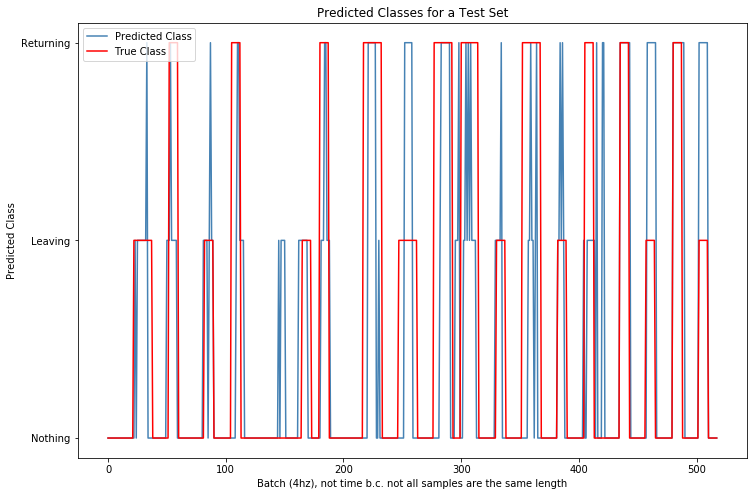

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(pred_final, color='steelblue')
ax.plot(label_final, color='red')
plt.title('Predicted Classes for a Test Set')
plt.legend(['Predicted Class','True Class'])
plt.yticks([0, 1, 2],['Nothing','Leaving','Returning'], rotation='horizontal')
ax.set_ylabel('Predicted Class')
ax.set_xlabel('Batch (4hz), not time b.c. not all samples are the same length')
plt.savefig("test_results.png", dpi=150)

## Looking much better
- Areas for improvment
    - ~~More diverse dataset~~ (2020-04-10)
    - ~~Hyperparameter tuning~~ (2020-04-29)
    - ~~Make video window overlapping~~ (2020-04-10)
    - ~~How to freeze some layers?~~ (2020-03-13)

In [31]:
weight_save_path=Path('/media/tris/tris_files/CSCE636-project-porta/porta_04.pth')
torch.save(my_model, weight_save_path)

In [32]:
from torch.autograd import Variable
from torchviz import make_dot, make_dot_from_trace
x=Variable(torch.randn(64,3,14,100,120))
y=my_model(x)

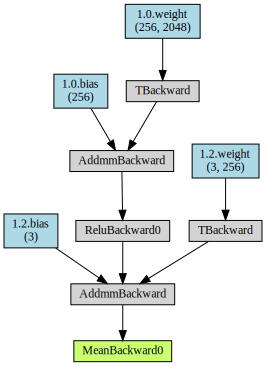

In [33]:
make_dot(y.mean(),params=dict(my_model.named_parameters()))